## UTILS

In [53]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

#load the breast cancer image/mask pairs
def create_list():
    directory = "Dataset_BUSI_with_GT"
    categories = ["benign", "malignant"]

    image_and_mask_list = []

    for category in categories:
        path = os.path.join(directory, category)
        #get all files in the folder
        files = os.listdir(path)

        #separate images and masks
        images = [f for f in files if not f.endswith("_mask*.png")]
        masks = [f for f in files if f.endswith("_mask.png")]

        #match images with their masks
        for image in images:
            mask_name = f"{os.path.splitext(image)[0]}_mask.png"
            if mask_name in masks:
                image_path = os.path.join(path, image)
                mask_path = os.path.join(path, mask_name)
                image_and_mask_list.append((image_path, mask_path))
    return image_and_mask_list

#load the skin cancer image/mask pairs
def create_list_skin(image_directory, mask_directory): #different for training, validation and test
    image_and_mask_list = []
    images = os.listdir(image_directory)
    masks = os.listdir(mask_directory)
    for image in images:
        if not image.endswith("_superpixels.png"):
            mask_name = f"{os.path.splitext(image)[0]}_segmentation.png"
            if mask_name in masks:
                image_path = os.path.join(image_directory, image)
                mask_path = os.path.join(mask_directory, mask_name)
                image_and_mask_list.append((image_path, mask_path))
    return image_and_mask_list

#load the brain cancer image/mask pairs
def create_list_brain():
    directory = "Brain_tumor_dataset"

    image_and_mask_list = []

    image_path = os.path.join(directory, "images")
    mask_path = os.path.join(directory, "masks")

    #get all files in both folders
    image_files = os.listdir(image_path)
    mask_files = os.listdir(mask_path)

    #match images with their masks
    common_names = set(image_files) & set(mask_files)

    for file in common_names:
        image_and_mask_list.append((os.path.join(image_path, file), os.path.join(mask_path, file)))

    return image_and_mask_list

#functions to map to the tensorflow dataset
def load_images_and_masks(image_path, mask_path):
    image_size = (256, 256)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_size)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, image_size)

    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask


def augment_image_and_mask(image, mask):

    #horizontal flip
    flip_hor = tf.random.uniform([]) > 0.5
    image = tf.cond(flip_hor, lambda: tf.image.flip_left_right(image), lambda: image)
    mask = tf.cond(flip_hor, lambda: tf.image.flip_left_right(mask), lambda: mask)

    #vertical flip
    flip_ver = tf.random.uniform([]) > 0.5
    image = tf.cond(flip_ver, lambda: tf.image.flip_up_down(image), lambda: image)
    mask = tf.cond(flip_ver, lambda: tf.image.flip_up_down(mask), lambda: mask)

    #rotation of -20° to +20°
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    #brightness change
    image = tf.image.random_brightness(image, max_delta=0.1)

    #contrast change
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    return image, mask

#function to create the tensorflow dataset
def create_dataset(pairs, augment=False):
    image_path = [pair[0] for pair in pairs]
    mask_path = [pair[1] for pair in pairs]

    dataset = tf.data.Dataset.from_tensor_slices((image_path, mask_path))

    dataset = dataset.map(load_images_and_masks)

    if augment:
        dataset = dataset.map(augment_image_and_mask)

    return dataset

#function to split the dataset into train/test/val
def split_dataset(image_and_mask_list):
    #split into training and validation/test
    train_pairs, val_test_pairs = train_test_split(image_and_mask_list, test_size=0.4, random_state=42)

    #split validation and test set
    val_pairs, test_pairs = train_test_split(val_test_pairs, test_size=0.5, random_state=42)

    return train_pairs, val_pairs, test_pairs


#functions to compute useful metrics
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    #flatten the tensors
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    #compute the intersection
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)

    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    #flatten the tensors
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    #compute the intersection and the union
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) - intersection

    return (intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def bce_dice_loss(y_true, y_pred, smooth=1e-6):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred, smooth)

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)
    return 1 - (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)

In [2]:
%%capture
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import tensorflow as tf

In [3]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## DATASETS

### Breast cancer dataset

In [54]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = split_dataset(create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [55]:
train_dataset_breast = create_dataset(train_pairs_breast, augment=False)
val_dataset_breast = create_dataset(val_pairs_breast)
test_dataset_breast = create_dataset(test_pairs_breast)

In [59]:
batch_size = 32

In [60]:
train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [7]:
train_dataset_skin = create_dataset(create_list_skin("ISIC-2017_Training_Data", "ISIC-2017_Training_Part1_GroundTruth"), augment=True)
val_dataset_skin = create_dataset(create_list_skin("ISIC-2017_Validation_Data", "ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin = create_dataset(create_list_skin("ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Part1_GroundTruth"))

In [8]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer dataset

In [9]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = split_dataset(create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

Number of training pairs: 1838
Number of val pairs: 613
Number of test_pairs pairs: 613


In [10]:
train_dataset_brain = create_dataset(train_pairs_brain, augment=True)
val_dataset_brain = create_dataset(val_pairs_brain)
test_dataset_brain = create_dataset(test_pairs_brain)

In [11]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [48]:
from keras import layers, Model

#function for encoder convolutional layers
def convolutional_layer(input, num_filters, kernel_size=(3, 3), initializer='he_normal'):

    #first convolution
    x = layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    #second convolution
    x = layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [49]:
def basic_unet(input_size, num_filters=16):
    inputs = tf.keras.Input(shape=input_size)

    #encoder block
    first_conv = convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)
    first_layer = layers.Dropout(0.3)(first_layer)

    second_conv = convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)
    second_layer = layers.Dropout(0.3)(second_layer)

    third_conv = convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)
    third_layer = layers.Dropout(0.3)(third_layer)

    fourth_conv = convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)
    fourth_layer = layers.Dropout(0.3)(fourth_layer)

    fifth_conv = convolutional_layer(fourth_layer, num_filters * 16)

    #decoder block
    first_deconv = layers.Conv2DTranspose(num_filters * 8, kernel_size=(3, 3), strides=(2, 2), padding='same')(fifth_conv)
    sixth_layer = layers.concatenate([first_deconv, fourth_conv])
    sixth_layer = layers.Dropout(0.3)(sixth_layer)
    sixth_conv = convolutional_layer(sixth_layer, num_filters * 8)

    second_deconv = layers.Conv2DTranspose(num_filters * 4, kernel_size=(3, 3), strides=(2, 2), padding='same')(sixth_conv)
    seventh_layer = layers.concatenate([second_deconv, third_conv])
    seventh_layer = layers.Dropout(0.3)(seventh_layer)
    seventh_conv = convolutional_layer(seventh_layer, num_filters * 4)

    third_deconv = layers.Conv2DTranspose(num_filters * 2, kernel_size=(3, 3), strides=(2, 2), padding='same')(seventh_conv)
    eighth_layer = layers.concatenate([third_deconv, second_conv])
    eighth_layer = layers.Dropout(0.3)(eighth_layer)
    eighth_conv = convolutional_layer(eighth_layer, num_filters * 2)

    fourth_deconv = layers.Conv2DTranspose(num_filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(eighth_conv)
    ninth_layer = layers.concatenate([fourth_deconv, first_conv])
    ninth_layer = layers.Dropout(0.3)(ninth_layer)
    ninth_conv = convolutional_layer(ninth_layer, num_filters)

    #output layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(ninth_conv)

    unet = Model(inputs=inputs, outputs=output)

    return unet

In [65]:
basic_unet.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_167 (Conv2D) │ (None, 256, 256,  │        448 │ input_layer_43[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_167[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_168 (Conv2D) │ (None, 256, 256,  │      2,320 │ activation_24[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ conv2d_168[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 128, 128,  │          0 │ activation_25[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 128, 128,  │          0 │ max_pooling2d_26… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_169 (Conv2D) │ (None, 128, 128,  │      4,640 │ dropout_36[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_169[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_170 (Conv2D) │ (None, 128, 128,  │      9,248 │ activation_26[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_170[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 64, 64,    │          0 │ activation_27[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 64, 64,    │          0 │ max_pooling2d_27

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [28]:
# tf.keras.utils.get_custom_objects()["dice_loss"] = utils.dice_loss
# tf.keras.utils.get_custom_objects()["bce_dice_loss"] = utils.bce_dice_loss
# tf.keras.utils.get_custom_objects()["tversky_loss"] = utils.tversky_loss
# tf.keras.utils.get_custom_objects()["dice_coefficient"] = utils.dice_coefficient
# tf.keras.utils.get_custom_objects()["iou"] = utils.iou

In [50]:
basic_unet = basic_unet(input_size=(256, 256, 3))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_adapter = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", mode = "max", factor=0.1, patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", mode= "max", patience=10, restore_best_weights=True)

basic_unet.compile(optimizer=optimizer, loss=tversky_loss, metrics=[dice_coefficient, iou, "accuracy"])

In [31]:
history = basic_unet.fit(train_dataset_breast, epochs=100, validation_data=val_dataset_breast, callbacks=[lr_adapter, early_stopping])

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 45s 739ms/step - accuracy: 0.4542 - dice_coefficient: 0.1936 - iou: 0.1086 - loss: 0.7330 - val_accuracy: 0.2826 - val_dice_coefficient: 0.1765 - val_iou: 0.0988 - val_loss: 0.7299 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 757ms/step - accuracy: 0.6812 - dice_coefficient: 0.2794 - iou: 0.1646 - loss: 0.6271 - val_accuracy: 0.3989 - val_dice_coefficient: 0.1999 - val_iou: 0.1136 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 796ms/step - accuracy: 0.7432 - dice_coefficient: 0.3257 - iou: 0.1966 - loss: 0.5786 - val_accuracy: 0.3555 - val_dice_coefficient: 0.1887 - val_iou: 0.1064 - val_loss: 0.7143 - learning_rate: 0.0010
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 39s 790ms/step - accuracy: 0.7685 - dice_coefficient: 0.3515 - iou: 0.2163 - loss: 0.5569 - val_accuracy: 0.5581 - val_dice_coefficient: 0.2453 - val_iou: 0.1434 - val_loss: 0.6421 - learning_rate: 0.0010
Epoch 5/100
49/49 ━━━━━━

In [32]:
basic_unet.save("basic_unet_tversky.h5")

In [33]:
test_loss, test_dice, test_iou, test_accuracy = basic_unet.evaluate(test_dataset_breast)

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9233 - dice_coefficient: 0.5958 - iou: 0.4313 - loss: 0.4110


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


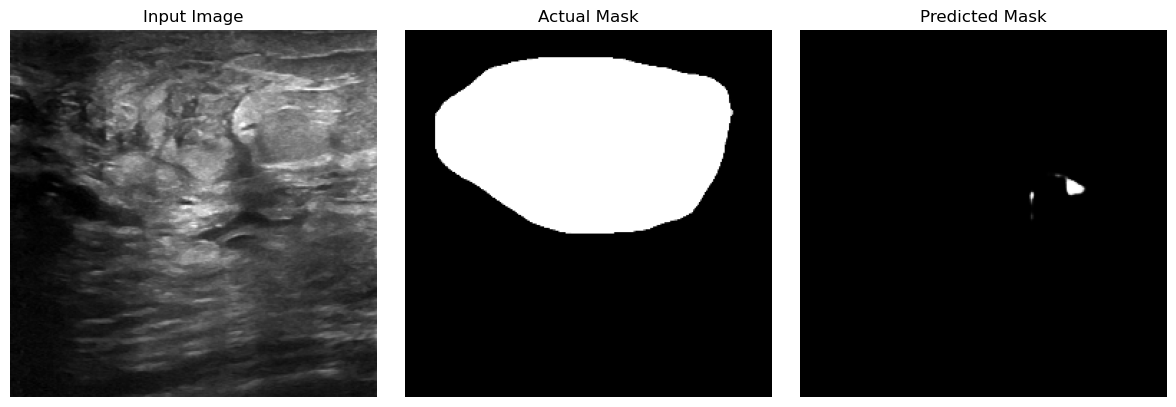

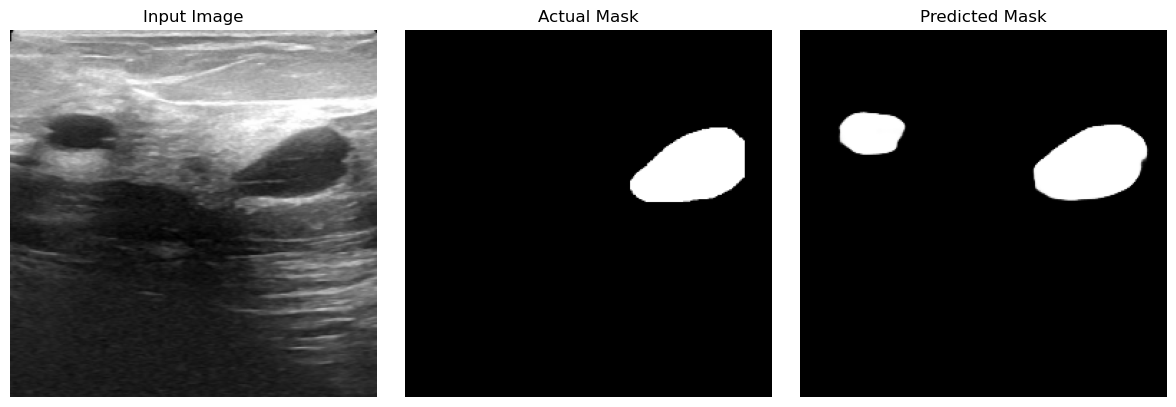

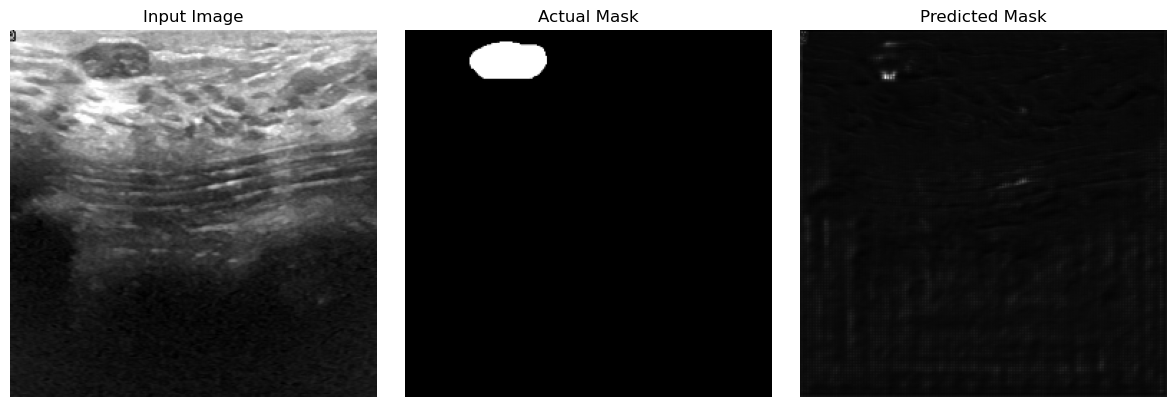

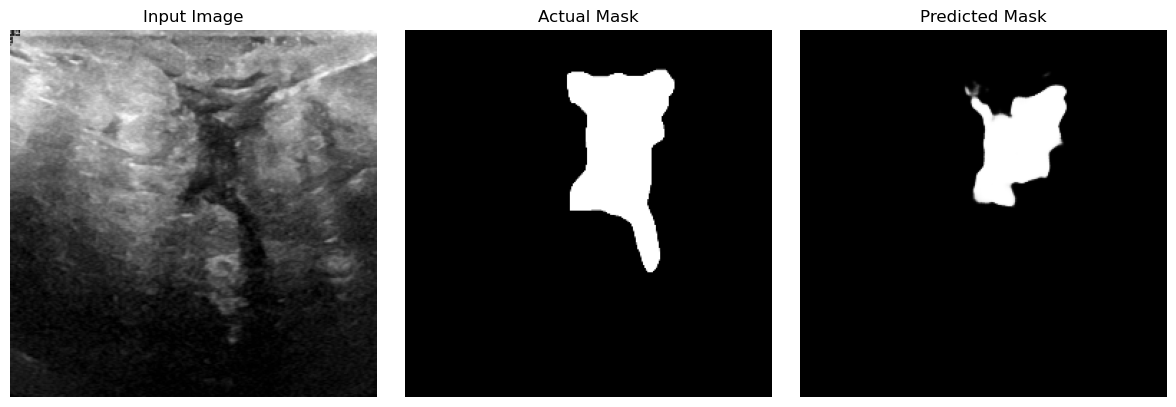

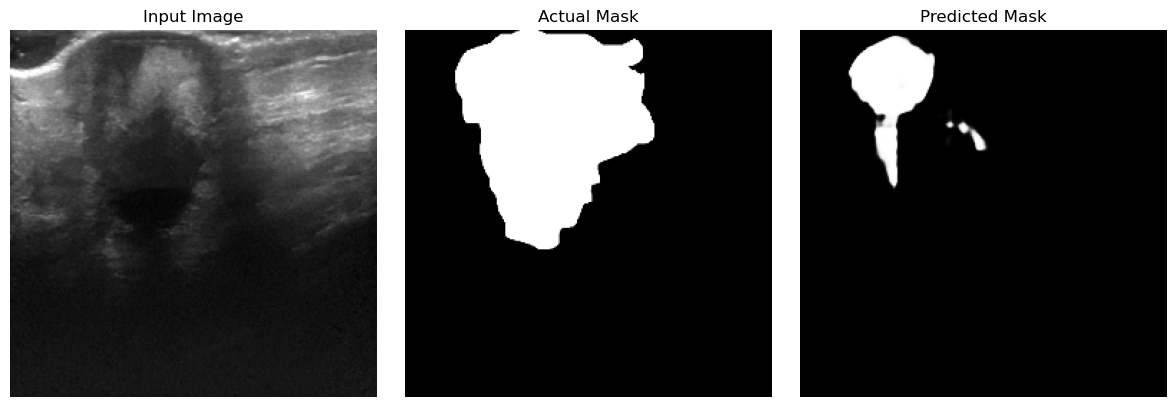

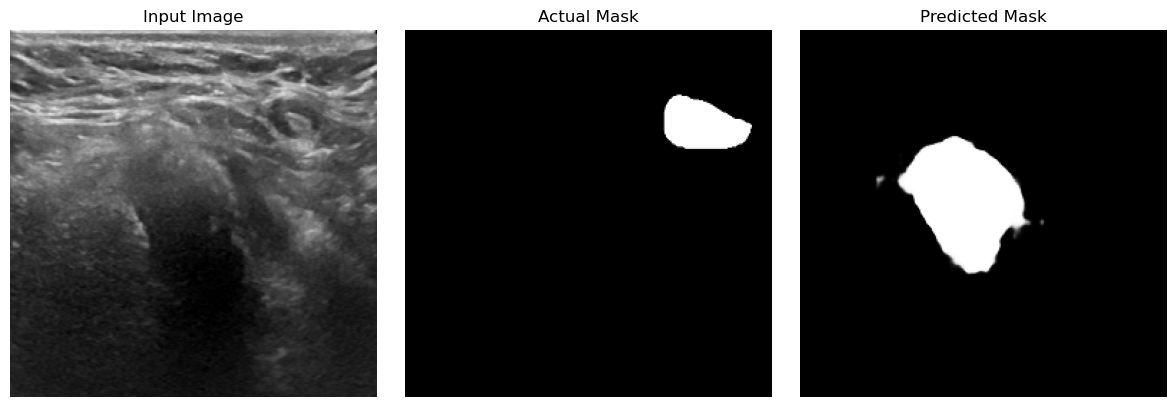

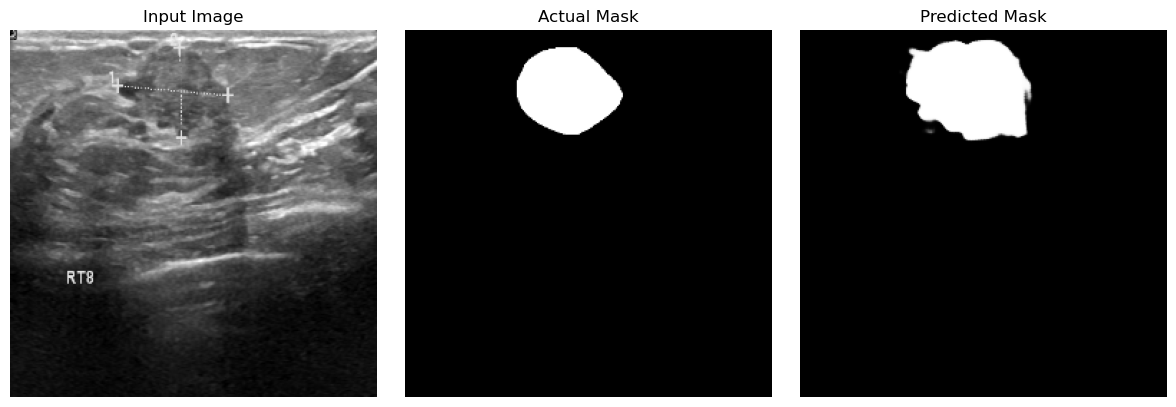

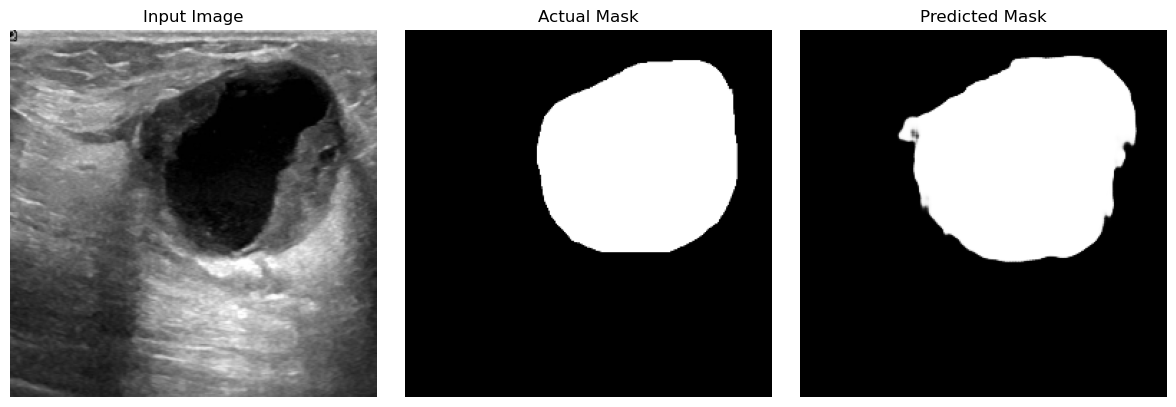

In [34]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = basic_unet.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [35]:
tf.keras.backend.clear_session()

## TRANSNET

In [70]:
class ChannelTransformer(layers.Layer):
    def __init__(self, num_heads=4, embed_dim=256, mlp_dim=512, dropout=0.8):
        super(ChannelTransformer, self).__init__()

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dense(embed_dim)
        ])
        self.dropout = layers.Dropout(dropout)

    def call(self, x):
        batch_size = tf.shape(x)[0]
        H, W, C = x.shape[1], x.shape[2], x.shape[3]

        x = tf.reshape(x, (batch_size, -1, C))
        attn_output = self.attention(x, x)
        x = self.norm1(x + attn_output)

        mlp_output = self.mlp(x)
        x = self.norm2(x + mlp_output)

        x = tf.reshape(x, (batch_size, H, W, C))
        return x

# ==============================
# 🔹 Channel-wise Cross Attention
# ==============================
class CCA(layers.Layer):
    def __init__(self, F_g, F_x):
        super(CCA, self).__init__()
        self.mlp_x = tf.keras.Sequential([
            layers.GlobalAveragePooling2D(),
            layers.Dense(F_x, activation='relu')
        ])
        self.mlp_g = tf.keras.Sequential([
            layers.GlobalAveragePooling2D(),
            layers.Dense(F_g, activation='relu')
        ])

    def call(self, g, x):
        channel_att_x = self.mlp_x(x)
        channel_att_g = self.mlp_g(g)

        scale = tf.expand_dims(tf.expand_dims(tf.nn.sigmoid((channel_att_x + channel_att_g) / 2.0), axis=1), axis=1)
        return x * scale

# ==============================
# 🔹 UCTransNet con Unet Pre-addestrato
# ==============================
def UCTransNet(input_shape=(256, 256, 3), pretrained_unet=None):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1 = pretrained_unet.get_layer(index=1)(inputs) if pretrained_unet else convolutional_layer(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = pretrained_unet.get_layer(index=3)(p1) if pretrained_unet else convolutional_layer(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = pretrained_unet.get_layer(index=5)(p2) if pretrained_unet else convolutional_layer(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    # Adattiamo p3 a 256 canali prima di passarlo al Transformer
    p3 = layers.Conv2D(256, (1, 1), padding='same')(p3)
    x4 = ChannelTransformer(num_heads=8, embed_dim=256, mlp_dim=512)(p3)

    # Decoder con CCA
    d1 = layers.UpSampling2D((2, 2))(x4)
    d1 = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(d1)

    x3 = layers.Conv2D(128, (1, 1), padding='same')(x3)  # 🔹 Correzione: x3 ora ha 128 canali
#     d1 = CCA(128, 128)(d1, x3)
    d1 = layers.Concatenate()([d1, x3])

    d2 = layers.UpSampling2D((2, 2))(d1)
    d2 = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(d2)

    x2 = layers.Conv2D(64, (1, 1), padding='same')(x2)  # 🔹 Correzione per x2
#     d2 = CCA(64, 64)(d2, x2)
    d2 = layers.Concatenate()([d2, x2])

    d3 = layers.UpSampling2D((2, 2))(d2)
    d3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(d3)

    x1 = layers.Conv2D(32, (1, 1), padding='same')(x1)  # 🔹 Correzione per x1
#     d3 = CCA(32, 32)(d3, x1)
    d3 = layers.Concatenate()([d3, x1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d3)

    return Model(inputs, outputs)

model = UCTransNet(input_shape = (256, 256, 3), pretrained_unet = basic_unet)
model.summary()

Model: "functional_77"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_84      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_167 (Conv2D) │ (None, 256, 256,  │        448 │ input_layer_84[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_45    │ (None, 128, 128,  │          0 │ conv2d_167[6][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (None, 128, 128,  │          0 │ max_pooling2d_45… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 64, 64,    │          0 │ activation_24[6]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │         64 │ max_pooling2d_46… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_226 (Conv2D) │ (None, 32, 32,    │      4,352 │ max_pooling2d_47… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel_transforme… │ (None, 32, 32,    │  2,367,488 │ conv2d_226[0][0]  │
│ (ChannelTransforme… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_41    │ (None, 64, 64,    │          0 │ channel_transfor… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_227 (Conv2D) │ (None, 64, 64,    │    295,040 │ up_sampling2d_41… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_228 (Conv2D) │ (None, 64, 64,    │      2,176 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 64, 64,    │          0 │ conv2d_227[0][0], │
│ (Concatenate)       │ 256)              │            │ conv2d_228[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_42    │ (None, 128, 128,  │          0 │ concatenate_44[0… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_229 (Conv2D) │ (None, 128, 128,  │    147,520 │ up_sampling2d_42… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_230 (Conv2D) │ (None, 128, 128,  │      1,088 │ activation_24[6]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 128, 128,  │          0 │ conv2d_229[0][0]

 Total params: 2,855,681 (10.89 MB)

 Trainable params: 2,855,649 (10.89 MB)

 Non-trainable params: 32 (128.00 B)

In [74]:
### PROVO IO
import tensorflow as tf
from keras import layers, Model
import numpy as np

class Patch_Embeddings(layers.Layer):
  def __init__(self, config, patch_size, img_size, in_channels):
    super(Patch_Embeddings, self).__init__()
    img_size = (img_size, img_size)
    patch_size = (patch_size, patch_size)
    self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

    self.patch_embeddings = tf.keras.layers.Conv2D(
        filters = in_channels,
        kernel_size = patch_size,
        strides = patch_size,
        padding = 'valid'
    )
    self.position_embeddings = self.add_weight(
            shape=(1, self.num_patches, in_channels),
            initializer="zeros",
            trainable=True,
            name="position_embeddings"
        )
    self.dropout = tf.keras.layers.Dropout(config["transformer"]["embeddings_dropout_rate"])

  def call(self, x, training = True):
      if x is None:
        return None

      x = self.patch_embeddings(x)
      x = tf.reshape(x,[tf.shape(x)[0], self.num_patches, -1])
      embeddings = x + self.position_embeddings
      embeddings = self.dropout(embeddings, training = training)
      return embeddings

class Reconstruction(layers.Layer):
  def __init__(self, in_channels, out_channels, kernel_size, scale_factor):
    super(Reconstruction, self).__init__()
    padding = "same" if kernel_size == 3 else "valid"

    self.conv = tf.keras.layers.Conv2D(
            filters=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            use_bias=False  # BatchNorm removes the need for bias
        )
    self.norm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.ReLU()
    self.scale_factor = scale_factor

    def call(self, x, training = False):
      if x is None:
        return None

      batch_size = tf.shape(x)[0]
      n_patches = tf.shape(x)[1]
      hidden = tf.shape(x)[2]
      
      h = w = tf.cast(tf.sqrt(tf.cast(n_patches, tf.float32)), tf.int32)

      x = tf.reshape(x, [batch_size, h, w, hidden])

      # è la parte di upsampling
      x = tf.image.resize(x, size=[h * self.scale_factor, w * self.scale_factor], method="bilinear")

      out = self.conv(x)
      out = self.norm(x, training=training)
      out = self.activation(x)

      return x

class Attention_Part(layers.Layer):
    def __init__(self, config, vis_flag, channel_num):
        super(Attention_Part, self).__init__()
        self.vis_flag = vis_flag
        self.keyvalue_size = config['keyvalue_size']
        self.channel_num = channel_num
        self.num_attention_heads = config["transformer"]["num_heads"]

        # Lists for query, key, and value layers
        self.query1 = []
        self.query2 = []
        self.query3 = []
        self.query4 = []
        self.key = []
        self.value = []

        for _ in range(config["transformer"]["num_heads"]):
            query1 = tf.keras.layers.Dense(channel_num[0], use_bias=False)
            query2 = tf.keras.layers.Dense(channel_num[1],use_bias=False)
            query3 = tf.keras.layers.Dense(channel_num[2], use_bias=False)
            query4 = tf.keras.layers.Dense(channel_num[3],use_bias=False)
            key = tf.keras.layers.Dense(self.keyvalue_size, use_bias=False)
            value = tf.keras.layers.Dense(self.keyvalue_size, use_bias=False)

            self.query1.append(copy.deepcopy(query1))
            self.query2.append(copy.deepcopy(query2))
            self.query3.append(copy.deepcopy(query3))
            self.query4.append(copy.deepcopy(query4))
            self.key.append(copy.deepcopy(key))
            self.value.append(copy.deepcopy(value))

            # al posto di instancenorm2d
            self.psi = tf.keras.layers.LayerNormalization(axis=[1, 2, 3])  

            # self.softmax = tf.nn.softmax

            self.out1 = tf.keras.layers.Dense(channel_num[0], use_bias=False)
            self.out2 = tf.keras.layers.Dense(channel_num[1], use_bias=False)
            self.out3 = tf.keras.layers.Dense(channel_num[2], use_bias=False)
            self.out4 = tf.keras.layers.Dense(channel_num[3], use_bias=False)


            self.attn_dropout = tf.keras.layers.Dropout(config["transformer"]["attention_dropout_rate"])
            self.proj_dropout = tf.keras.layers.Dropout(config["transformer"]["attention_dropout_rate"])

    def call(self, emb1, emb2, emb3, emb4, all_embs, training = True):
            multi_head_Q1_list = []
            multi_head_Q2_list = []
            multi_head_Q3_list = []
            multi_head_Q4_list = []
            multi_head_K_list = []
            multi_head_V_list = []

            if emb1 is not None:
              for query1 in self.query1:
                Q1 = query1(emb1)
                # Q1 = tf.expand_dims(Q1, axis=-1) 
                multi_head_Q1_list.append(Q1)
            if emb2 is not None:
              for query2 in self.query2:
                  Q2 = query2(emb2)
                  # Q2 = tf.expand_dims(Q2, axis=-1) 
                  multi_head_Q2_list.append(Q2)
            if emb3 is not None:
              for query3 in self.query3:
                Q3 = query3(emb3)
                # Q3 = tf.expand_dims(Q3, axis=-1) 
                multi_head_Q3_list.append(Q3)
            if emb4 is not None:
                for query4 in self.query4:
                  Q4 = query4(emb4)
                  # Q4 = tf.expand_dims(Q4, axis=-1)  ##### NON SO
                  multi_head_Q4_list.append(Q4)

        # Process keys and values
            for key in self.key:
              K = key(all_embs)
              multi_head_K_list.append(K)
            for value in self.value:
              V = value(all_embs)
              multi_head_V_list.append(V)

            multi_head_Q1 = tf.stack(multi_head_Q1_list, axis=1) if emb1 is not None else None
            multi_head_Q2 = tf.stack(multi_head_Q2_list, axis=1) if emb2 is not None else None
            multi_head_Q3 = tf.stack(multi_head_Q3_list, axis=1) if emb3 is not None else None
            multi_head_Q4 = tf.stack(multi_head_Q4_list, axis=1) if emb4 is not None else None
            multi_head_K = tf.stack(multi_head_K_list, axis=1)
            multi_head_V = tf.stack(multi_head_V_list, axis=1)

        # Transpose queries (if not None)
            multi_head_Q1 = tf.transpose(multi_head_Q1, perm=[0, 2, 1]) if emb1 is not None else None
            multi_head_Q2 = tf.transpose(multi_head_Q2, perm=[0, 2, 1]) if emb2 is not None else None
            multi_head_Q3 = tf.transpose(multi_head_Q3, perm=[0, 2, 1]) if emb3 is not None else None
            multi_head_Q4 = tf.transpose(multi_head_Q4, perm=[0, 2, 1]) if emb4 is not None else None

            attention_scores1 = tf.matmul(multi_head_Q1, multi_head_K, transpose_b=True) if emb1 is not None else None
            attention_scores2 = tf.matmul(multi_head_Q2, multi_head_K, transpose_b=True) if emb2 is not None else None
            attention_scores3 = tf.matmul(multi_head_Q3, multi_head_K, transpose_b=True) if emb3 is not None else None
            attention_scores4 = tf.matmul(multi_head_Q4, multi_head_K, transpose_b=True) if emb4 is not None else None

        # Scale the attention scores by sqrt(KV_size)
            attention_scores1 = attention_scores1 / tf.sqrt(float(self.keyvalue_size)) if emb1 is not None else None
            attention_scores2 = attention_scores2 / tf.sqrt(float(self.keyvalue_size)) if emb2 is not None else None
            attention_scores3 = attention_scores3 / tf.sqrt(float(self.keyvalue_size)) if emb3 is not None else None
            attention_scores4 = attention_scores4 / tf.sqrt(float(self.keyvalue_size)) if emb4 is not None else None

        # Apply softmax to get attention probabilities
            attention_probs1 = tf.nn.softmax(self.psi(attention_scores1), axis=-1) if emb1 is not None else None
            attention_probs2 = tf.nn.softmax(self.psi(attention_scores2), axis=-1) if emb2 is not None else None
            attention_probs3 = tf.nn.softmax(self.psi(attention_scores3), axis=-1) if emb3 is not None else None
            attention_probs4 = tf.nn.softmax(self.psi(attention_scores4), axis=-1) if emb4 is not None else None

            if self.vis_flag:
              weights =  []
              weights.append(attention_probs1.mean(1))
              weights.append(attention_probs2.mean(1))
              weights.append(attention_probs3.mean(1))
              weights.append(attention_probs4.mean(1))
            else: weights=None

            attention_probs1 = self.attn_dropout(attention_probs1) if emb1 is not None else None
            attention_probs2 = self.attn_dropout(attention_probs2) if emb2 is not None else None
            attention_probs3 = self.attn_dropout(attention_probs3) if emb3 is not None else None
            attention_probs4 = self.attn_dropout(attention_probs4) if emb4 is not None else None

            context_layer1 = tf.matmul(attention_probs1, multi_head_V, transpose_b=True) if emb1 is not None else None
            context_layer2 = tf.matmul(attention_probs2, multi_head_V, transpose_b=True) if emb2 is not None else None
            context_layer3 = tf.matmul(attention_probs3, multi_head_V, transpose_b=True) if emb3 is not None else None
            context_layer4 = tf.matmul(attention_probs4, multi_head_V, transpose_b=True) if emb4 is not None else None

            context_layer1 = tf.transpose(context_layer1, perm=[0, 3, 2, 1]) if emb1 is not None else None
            context_layer2 = tf.transpose(context_layer2, perm=[0, 3, 2, 1]) if emb2 is not None else None
            context_layer3 = tf.transpose(context_layer3, perm=[0, 3, 2, 1]) if emb3 is not None else None
            context_layer4 = tf.transpose(context_layer4, perm=[0, 3, 2, 1]) if emb4 is not None else None

            context_layer1 = tf.reduce_mean(context_layer1, axis=-1) if emb1 is not None else None
            context_layer2 = tf.reduce_mean(context_layer2, axis=-1) if emb2 is not None else None
            context_layer3 = tf.reduce_mean(context_layer3, axis=-1) if emb3 is not None else None
            context_layer4 = tf.reduce_mean(context_layer4, axis=-1) if emb4 is not None else None  

            O1 = self.out1(context_layer1) if emb1 is not None else None
            O2 = self.out2(context_layer2) if emb2 is not None else None
            O3 = self.out3(context_layer3) if emb3 is not None else None
            O4 = self.out4(context_layer4) if emb4 is not None else None
            O1 = self.proj_dropout(O1) if emb1 is not None else None
            O2 = self.proj_dropout(O2) if emb2 is not None else None
            O3 = self.proj_dropout(O3) if emb3 is not None else None
            O4 = self.proj_dropout(O4) if emb4 is not None else None
            return O1,O2,O3,O4, weights

class Mlp(layers.Layer):
    def __init__(self, config, in_channel, mlp_channel):
        super(Mlp, self).__init__()
        self.fc1 = layers.Dense(mlp_channel, input_dim=in_channel, activation="gelu")
        self.fc2 = layers.Dense(in_channel)
        self.dropout = layers.Dropout(config["transformer"]["dropout_rate"])
        self._init_weights()

    def _init_weights(self):
        # Xavier initialization (Glorot initialization) for weights
        initializer = tf.keras.initializers.GlorotUniform()
        self.fc1.kernel_initializer = initializer
        self.fc2.kernel_initializer = initializer
        self.fc1.bias_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-6)
        self.fc2.bias_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-6)

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.dropout(x, training=training)
        x = self.fc2(x)
        x = self.dropout(x, training=training)
        return x

class Vision_Transformer(layers.Layer):
    def __init__(self, config, vis_flag, channel_num):
        super(Vision_Transformer, self).__init__()
        expand_ratio = config["expand_ratio"]

        self.attn_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm4 = layers.LayerNormalization(epsilon=1e-6)
        self.attn_norm = layers.LayerNormalization(epsilon=1e-6)

        self.channel_attn = Attention_Part(config, vis_flag, channel_num)
        
        self.ffn_norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_norm3 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_norm4 = layers.LayerNormalization(epsilon=1e-6)

        self.ffn1 = Mlp(config, channel_num[0], channel_num[0] * expand_ratio)
        self.ffn2 = Mlp(config, channel_num[1], channel_num[1] * expand_ratio)
        self.ffn3 = Mlp(config, channel_num[2], channel_num[2] * expand_ratio)
        self.ffn4 = Mlp(config, channel_num[3], channel_num[3] * expand_ratio)

    def call(self, emb1, emb2, emb3, emb4, training=False):
        emb_list = []

        # Store original embeddings
        org1, org2, org3, org4 = emb1, emb2, emb3, emb4

        if emb1 is not None:
            emb_list.append(emb1)
        if emb2 is not None:
            emb_list.append(emb2)
        if emb3 is not None:
            emb_list.append(emb3)
        if emb4 is not None:
            emb_list.append(emb4)

        all_embs = tf.concat(emb_list, axis=-1)

        cx1 = self.attn_norm1(emb1) if emb1 is not None else None
        cx2 = self.attn_norm2(emb2) if emb2 is not None else None
        cx3 = self.attn_norm3(emb3) if emb3 is not None else None
        cx4 = self.attn_norm4(emb4) if emb4 is not None else None

        all_embs = self.attn_norm(all_embs)

        cx1, cx2, cx3, cx4, weights = self.channel_attn(cx1, cx2, cx3, cx4, all_embs)

        cx1 = org1 + cx1 if emb1 is not None else None
        cx2 = org2 + cx2 if emb2 is not None else None
        cx3 = org3 + cx3 if emb3 is not None else None
        cx4 = org4 + cx4 if emb4 is not None else None

        org1, org2, org3, org4 = cx1, cx2, cx3, cx4
        x1 = self.ffn_norm1(cx1) if emb1 is not None else None
        x2 = self.ffn_norm2(cx2) if emb2 is not None else None
        x3 = self.ffn_norm3(cx3) if emb3 is not None else None
        x4 = self.ffn_norm4(cx4) if emb4 is not None else None
        x1 = self.ffn1(x1) if emb1 is not None else None
        x2 = self.ffn2(x2) if emb2 is not None else None
        x3 = self.ffn3(x3) if emb3 is not None else None
        x4 = self.ffn4(x4) if emb4 is not None else None
        x1 = x1 + org1 if emb1 is not None else None
        x2 = x2 + org2 if emb2 is not None else None
        x3 = x3 + org3 if emb3 is not None else None
        x4 = x4 + org4 if emb4 is not None else None

        return x1, x2, x3, x4, weights

class Encoder(tf.keras.layers.Layer):
    def __init__(self, config, vis_flag, channel_num):
        super(Encoder, self).__init__()
        self.vis_flag = vis_flag

        # Create a list to hold the layers
        self.layers_list = []
        
        # Layer Normalization for each channel
        self.encoder_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.encoder_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.encoder_norm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.encoder_norm4 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # Adding multiple Block_ViT layers to the layers list
        for _ in range(config["transformer"]["num_layers"]):
            layer = Vision_Transformer(config, vis_flag, channel_num)  
            self.layers_list.append(layer)
    def call(self, emb1, emb2, emb3, emb4):
        attn_weights = []
        
        # Apply each layer in the layers list to the inputs
        for layer_block in self.layers_list:
            emb1, emb2, emb3, emb4, weights = layer_block(emb1, emb2, emb3, emb4)
            if self.vis:
                attn_weights.append(weights)
        
        # Normalize the embeddings if they are not None
        emb1 = self.encoder_norm1(emb1) if emb1 is not None else None
        emb2 = self.encoder_norm2(emb2) if emb2 is not None else None
        emb3 = self.encoder_norm3(emb3) if emb3 is not None else None
        emb4 = self.encoder_norm4(emb4) if emb4 is not None else None
        
        return emb1, emb2, emb3, emb4, attn_weights

class ChannelTransformer(tf.keras.layers.Layer):
    def __init__(self, config, vis_flag, img_size, channel_num=[64, 128, 256, 512], patch_size=[32, 16, 8, 4]):
        super(ChannelTransformer, self).__init__()

        # Define patch sizes for each channel embedding
        self.patch_size_1 = patch_size[0]
        self.patch_size_2 = patch_size[1]
        self.patch_size_3 = patch_size[2]
        self.patch_size_4 = patch_size[3]

        # Initialize the channel embeddings for each patch size
        self.embeddings_1 = Patch_Embeddings(config, self.patch_size_1, img_size=img_size, in_channels=channel_num[0])
        self.embeddings_2 = Patch_Embeddings(config, self.patch_size_2, img_size=img_size // 2, in_channels=channel_num[1])
        self.embeddings_3 = Patch_Embeddings(config, self.patch_size_3, img_size=img_size // 4, in_channels=channel_num[2])
        self.embeddings_4 = Patch_Embeddings(config, self.patch_size_4, img_size=img_size // 8, in_channels=channel_num[3])

        # Initialize the encoder for the model
        self.encoder = Encoder(config, vis_flag, channel_num)

        # Define the reconstruction layers
        self.reconstruct_1 = Reconstruction(channel_num[0], channel_num[0], kernel_size=1, scale_factor=(self.patch_size_1, self.patch_size_1))
        self.reconstruct_2 = Reconstruction(channel_num[1], channel_num[1], kernel_size=1, scale_factor=(self.patch_size_2, self.patch_size_2))
        self.reconstruct_3 = Reconstruction(channel_num[2], channel_num[2], kernel_size=1, scale_factor=(self.patch_size_3, self.patch_size_3))
        self.reconstruct_4 = Reconstruction(channel_num[3], channel_num[3], kernel_size=1, scale_factor=(self.patch_size_4, self.patch_size_4))

    def call(self, en1, en2, en3, en4):
        # Apply embeddings for each channel
        emb1 = self.embeddings_1(en1)
        emb2 = self.embeddings_2(en2)
        emb3 = self.embeddings_3(en3)
        emb4 = self.embeddings_4(en4)

        # Apply encoder block to each embedding
        encoded1, encoded2, encoded3, encoded4, attn_weights = self.encoder(emb1, emb2, emb3, emb4)

        # Apply reconstruction layer for each encoding
        x1 = self.reconstruct_1(encoded1) if en1 is not None else None
        x2 = self.reconstruct_2(encoded2) if en2 is not None else None
        x3 = self.reconstruct_3(encoded3) if en3 is not None else None
        x4 = self.reconstruct_4(encoded4) if en4 is not None else None

        # Add the original input to the reconstructed output if it's not None
        x1 = x1 + en1 if en1 is not None else None
        x2 = x2 + en2 if en2 is not None else None
        x3 = x3 + en3 if en3 is not None else None
        x4 = x4 + en4 if en4 is not None else None

        return x1, x2, x3, x4, attn_weights

def conv_layers(in_channels, out_channels, num_conv, activation='ReLU'):
    layers = []
    
    # Add the first ConvBatchNorm layer
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))

    # Add the remaining ConvBatchNorm layers
    for _ in range(num_conv - 1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))

    # Return a sequential model
    return tf.keras.Sequential(layers)

class ConvBatchNorm(layers.Layer):
    """(convolution => [BN] => ReLU)"""
    
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ConvBatchNorm, self).__init__()
        
        # Convolutional layer with 3x3 kernel and padding=1
        self.conv = tf.keras.layers.Conv2D(out_channels, kernel_size=3, padding='same', input_shape=(None, None, in_channels))
        
        # Batch normalization layer
        self.norm = tf.keras.layers.BatchNormalization()
        
        # ReLU activation
        self.activation = tf.keras.activations.relu

    def call(self, x):
        out = self.conv(x)  # Apply convolution
        out = self.norm(out)  # Apply batch normalization
        return self.activation(out)  # Apply ReLU activation

class Downscaler(tf.keras.layers.Layer):
    """Downscaling with maxpool convolution"""
    def __init__(self, in_channels, out_channels, num_conv, activation='ReLU'):
        super(Downscaler, self).__init__()
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
        self.nConvs = conv_layers(in_channels, out_channels, num_conv, activation)

    def call(self, x):
        out = self.maxpool(x)
        return self.nConvs(out)

# class Flatten(tf.keras.layers.Layer):
#     def call(self, x):
#         return tf.reshape(x, (x.shape[0], -1))

class CCA(tf.keras.layers.Layer):
    """
    CCA Block
    """
    def __init__(self, F_g, F_x):
        super(CCA, self).__init__()
        # MLP for x
        self.mlp_x = tf.keras.Sequential([
            tf.keras.layers.Reshape((-1,)),
            tf.keras.layers.Dense(F_x)
        ])
        # MLP for g
        self.mlp_g = tf.keras.Sequential([
            tf.keras.layers.Reshape((-1,)),
            tf.keras.layers.Dense(F_g)  # Using F_g for the number of units here
        ])
        self.relu = tf.keras.layers.ReLU()


        def call(self, g, x):
        # Channel-wise attention
          avg_pool_x = self.global_avg_pool(x)  # Global average pooling on x
          avg_pool_x = tf.expand_dims(avg_pool_x, 1)  # Adding a second dimension for compatibility
          avg_pool_x = tf.expand_dims(avg_pool_x, 1)  # Adding a third dimension
        
          channel_att_x = self.mlp_x(avg_pool_x)
        
          avg_pool_g = self.global_avg_pool(g)  # Global average pooling on g
          avg_pool_g = tf.expand_dims(avg_pool_g, 1)  # Adding a second dimension for compatibility
          avg_pool_g = tf.expand_dims(avg_pool_g, 1)  # Adding a third dimension
        
          channel_att_g = self.mlp_g(avg_pool_g)

        # Calculate the sum of the channel attentions
          channel_att_sum = (channel_att_x + channel_att_g) / 2.0
        
        # Apply sigmoid activation and expand the dimensions to match x
          scale = tf.sigmoid(channel_att_sum)
          scale = tf.expand_dims(scale, 2)
          scale = tf.expand_dims(scale, 3)
        
        # Apply the scale to x
          x_after_channel = x * scale
        
        # Apply ReLU activation
          out = self.relu(x_after_channel)
          return out

class UpSampler(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, num_conv, activation='ReLU'):
        super(UpSampler, self).__init__()
        self.up = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')
        self.cca = CCA(F_g=in_channels // 2, F_x=in_channels // 2)
        self.nConvs = conv_layers(in_channels, out_channels, num_conv, activation)

    def call(self, x, skip_x):
    # Perform upsampling
        up = self.up(x)
    
    # Apply channel-wise attention (CCA)
        skip_x_att = self.cca(up, skip_x)
    
    # Concatenate along the channel dimension (axis=-1)
        x = tf.concat([skip_x_att, up], axis=-1)
    
    # Apply convolutions
        return self.nConvs(x)

class UCTransNet(tf.keras.Model):
    def __init__(self, config, n_channels=3, n_classes=1, img_size=224, vis_flag=False):
        super(UCTransNet, self).__init__()
        self.vis_flag = vis_flag
        self.n_channels = n_channels
        self.n_classes = n_classes
        in_channels = config['base_channel']

        # Initial convolution block
        self.initial_conv = ConvBatchNorm(n_channels, in_channels)

        # Downsampling blocks
        self.down1 = Downscaler(in_channels, in_channels*2, num_conv=2)
        self.down2 = Downscaler(in_channels*2, in_channels*4, num_conv=2)
        self.down3 = Downscaler(in_channels*4, in_channels*8, num_conv=2)
        self.down4 = Downscaler(in_channels*8, in_channels*8, num_conv=2)

        # Channel Transformer module
        self.CT = ChannelTransformer(config, vis_flag, img_size,
                                     channel_num=[in_channels, in_channels*2, in_channels*4, in_channels*8],
                                     patch_size=config["patch_sizes"])

        # Upsampling blocks with attention
        self.up4 = UpSampler(in_channels*16, in_channels*4, num_conv=2)
        self.up3 = UpSampler(in_channels*8, in_channels*2, num_conv=2)
        self.up2 = UpSampler(in_channels*4, in_channels, num_conv=2)
        self.up1 = UpSampler(in_channels*2, in_channels, num_conv=2)

        # Output convolutional layer
        self.outc = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1), strides=(1, 1))

        # Sigmoid activation for binary classification (BCELoss)
        self.last_activation = tf.keras.activations.sigmoid

    def call(self, x):
        x = tf.cast(x, tf.float32)  # Ensure the input is float32 (like x.float() in PyTorch)
    
        x1 = self.initial_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
    
    # Channel transformer (returns attention weights as well)
        x1, x2, x3, x4, attn_weights = self.CT(x1, x2, x3, x4)
    
    # Upsampling blocks
        x = self.up4(x5, x4)
        x = self.up3(x, x3)
        x = self.up2(x, x2)
        x = self.up1(x, x1)
    
    # Output layer with activation (Sigmoid for binary classification or just logits for multi-class)
        if self.n_classes == 1:
            logits = self.last_activation(self.outc(x))
        else:
            logits = self.outc(x)  # For multi-class or BCEWithLogitsLoss
    
        if self.vis:  # Option to visualize the attention maps
            return logits, attn_weights
        else:
            return logits



import copy
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
config = {
    'base_channel': 64,  # Starting number of channels (typically, this is the first channel size)
    'patch_sizes': [32, 16, 8, 4],  # Patch sizes at each level of the transformer
    'transformer': {
        'num_layers': 4,  # Number of transformer layers
        'hidden_dim': 512,  # Hidden dimension size for transformer layers (if needed)
        'num_heads': 8,  # Number of attention heads in the transformer
        'embeddings_dropout_rate': 0.1,  # Add embeddings_dropout_rate
        'attention_dropout_rate': 0.1,  # Add attention_dropout_rate
        'dropout_rate': 0.1  
    },
    'activation': 'ReLU',  # Activation function to be used in ConvBatchNorm and other layers
    'dropout': 0.1,  # Dropout rate (if required)
    'learning_rate': 1e-4,  # Learning rate for the optimizer
    'batch_size': 8,  # Batch size for training
    'num_epochs': 50,  # Number of epochs for training
    'img_size': 256,  # Input image size (e.g., 224x224 for standard image size)
    'n_channels': 3,  # Number of input channels (RGB = 3)
    'n_classes': 1,  # Number of output classes (1 for binary segmentation, >1 for multi-class)
    'optimizer': 'adam',  # Optimizer type ('adam', 'sgd', etc.)
    'loss_fn': 'binary_crossentropy',  # Loss function for training (adjust based on task)
    'metrics': [dice_coefficient, iou, 'accuracy'],  # Metrics to evaluate during training
    'vis': False,  # Set to True if you need to visualize attention weights
    'expand_ratio': 4,
    'keyvalue_size': 64
}

model_prova = UCTransNet(config = config, n_channels=3, n_classes=1, img_size=256, vis_flag=False)

model_prova.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=config['loss_fn'],
              metrics=config['metrics'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model_prova.fit(
    train_dataset_breast,  # Assuming this is a TensorFlow Dataset or DataGenerator
    epochs=config['num_epochs'],
    batch_size=config['batch_size'],
    validation_data=val_dataset_breast,  # TensorFlow Dataset or DataGenerator
    callbacks=callbacks
)

C:\Users\bongi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bongi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [12]:
# import tensorflow as tf
# from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Dense, Dropout, LayerNormalization, UpSampling2D, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# import numpy as np

# class ChannelEmbeddings(tf.keras.layers.Layer):
#     def __init__(self, patch_size, img_size, in_channels, dropout_rate):
#         super(ChannelEmbeddings, self).__init__()
#         self.patch_size = patch_size
#         self.in_channels = in_channels
#         self.patch_embeddings = Conv2D(in_channels, kernel_size=patch_size, strides=patch_size)
#         n_patches = (img_size // patch_size) ** 2
#         self.position_embeddings = self.add_weight(shape=(1, n_patches, in_channels), initializer='zeros', trainable=True)
#         self.dropout = Dropout(dropout_rate)

#     def call(self, x):
#         x = self.patch_embeddings(x)
#         x = tf.reshape(x, [tf.shape(x)[0], -1, self.in_channels])
#         embeddings = x + self.position_embeddings
#         return self.dropout(embeddings)

# class ChannelAttention(tf.keras.layers.Layer):
#     def __init__(self, num_heads, channel_num, kv_size, dropout_rate):
#         super(ChannelAttention, self).__init__()
#         self.num_heads = num_heads
#         self.kv_size = kv_size
#         self.query_layers = [Dense(kv_size, use_bias=False) for _ in channel_num]  # Change output size to match key
#         self.key_layer = Dense(kv_size, use_bias=False)
#         self.value_layer = Dense(kv_size, use_bias=False)
#         self.softmax = tf.keras.layers.Softmax(axis=-1)
#         self.dropout = Dropout(dropout_rate)

#     def call(self, queries, key_value):
#         # Project all queries to match key-value size
#         q_layers = [q(query) if query is not None else None for q, query in zip(self.query_layers, queries)]
#         q_layers = [q for q in q_layers if q is not None]  # Remove None values

#         k = self.key_layer(key_value)  # (batch, 64, kv_size)
#         v = self.value_layer(key_value)

#         attention_scores = [tf.matmul(q, k, transpose_b=True) / tf.sqrt(float(self.kv_size)) for q in q_layers]
#         attention_probs = [self.softmax(score) for score in attention_scores]
#         attention_probs = [self.dropout(prob) for prob in attention_probs]

#         outputs = [tf.matmul(prob, v) for prob in attention_probs]
#         return outputs


# class ChannelTransformer(tf.keras.layers.Layer):
#     def __init__(self, img_size, channel_nums, patch_sizes, num_heads, kv_size, dropout_rate):
#         super(ChannelTransformer, self).__init__()
#         self.embeddings = [ChannelEmbeddings(ps, img_size // (2 ** i), cn, dropout_rate) for i, (ps, cn) in enumerate(zip(patch_sizes, channel_nums))]
#         self.attention = ChannelAttention(num_heads, channel_nums, kv_size, dropout_rate)
    
#     def call(self, inputs):
#         embeddings = [embed(inp) if inp is not None else None for embed, inp in zip(self.embeddings, inputs)]
#         key_value = tf.concat([e for e in embeddings if e is not None], axis=-1)
#         outputs = self.attention(embeddings, key_value)
#         return outputs


In [71]:
# Compile the model with optimizer and custom loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=dice_loss, metrics=[dice_coefficient, iou, 'accuracy'])

# Training the model
model.fit(train_dataset_breast, validation_data=val_dataset_breast, epochs=5)


Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 351s 26s/step - accuracy: 0.4099 - dice_coefficient: 0.1902 - iou: 0.1061 - loss: 0.8117 - val_accuracy: 0.7677 - val_dice_coefficient: 0.1547 - val_iou: 0.0862 - val_loss: 0.8081
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 361s 28s/step - accuracy: 0.6400 - dice_coefficient: 0.2189 - iou: 0.1239 - loss: 0.7811 - val_accuracy: 0.8632 - val_dice_coefficient: 0.1569 - val_iou: 0.0874 - val_loss: 0.8081
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 415s 30s/step - accuracy: 0.6227 - dice_coefficient: 0.2186 - iou: 0.1231 - loss: 0.7813 - val_accuracy: 0.5103 - val_dice_coefficient: 0.1583 - val_iou: 0.0883 - val_loss: 0.8044
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 403s 27s/step - accuracy: 0.6046 - dice_coefficient: 0.2304 - iou: 0.1307 - loss: 0.7687 - val_accuracy: 0.2377 - val_dice_coefficient: 0.1441 - val_iou: 0.0794 - val_loss: 0.8230
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 450s 35s/step - accuracy: 0.7556 - dice_coefficient: 0.2663 - iou: 0.1554 - loss: 0.7322 - val_

In [72]:
test_loss, test_dice, test_iou, test_accuracy = model.evaluate(test_dataset_breast)

5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.3418 - dice_coefficient: 0.2062 - iou: 0.1156 - loss: 0.7960


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


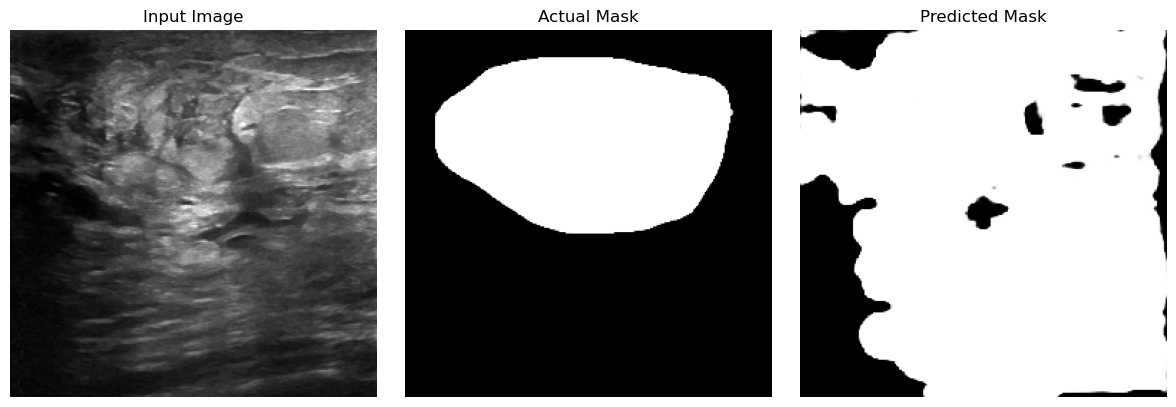

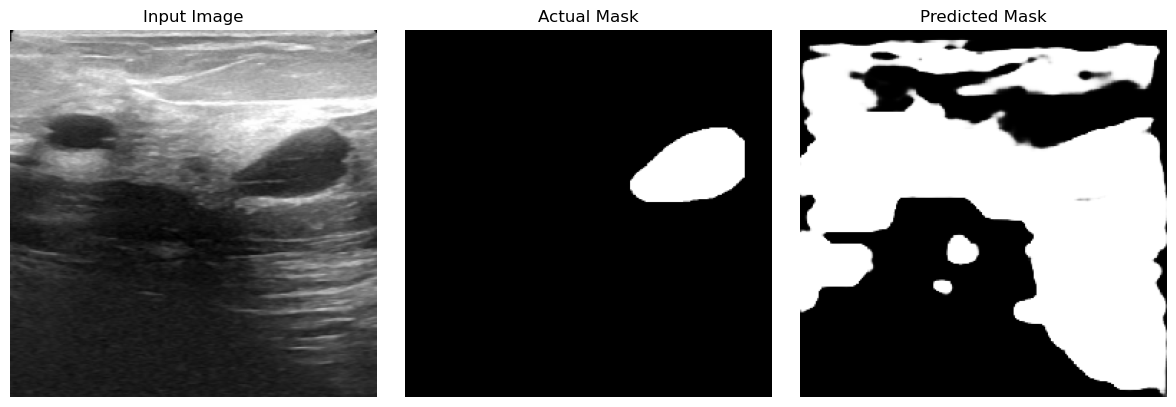

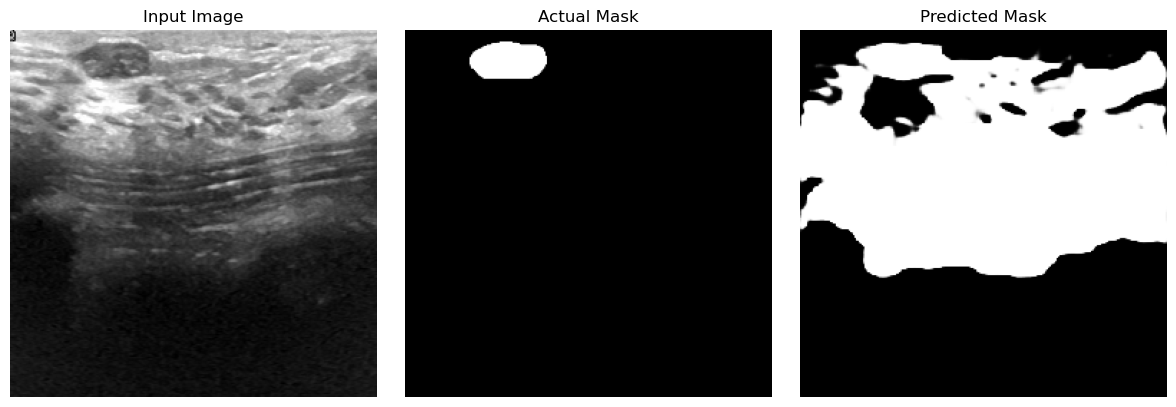

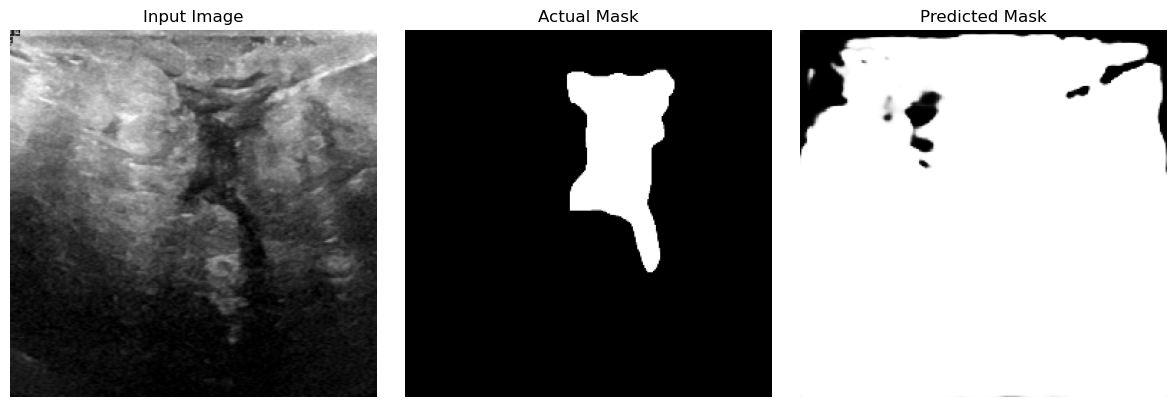

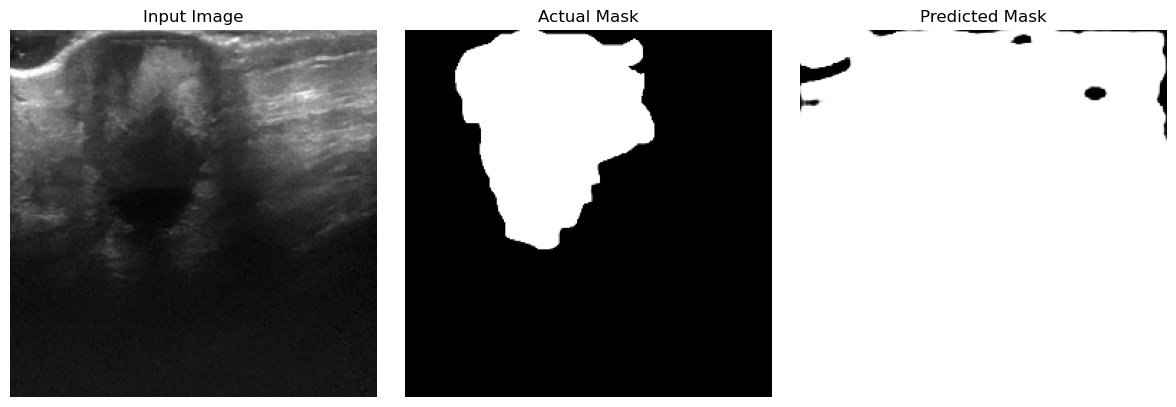

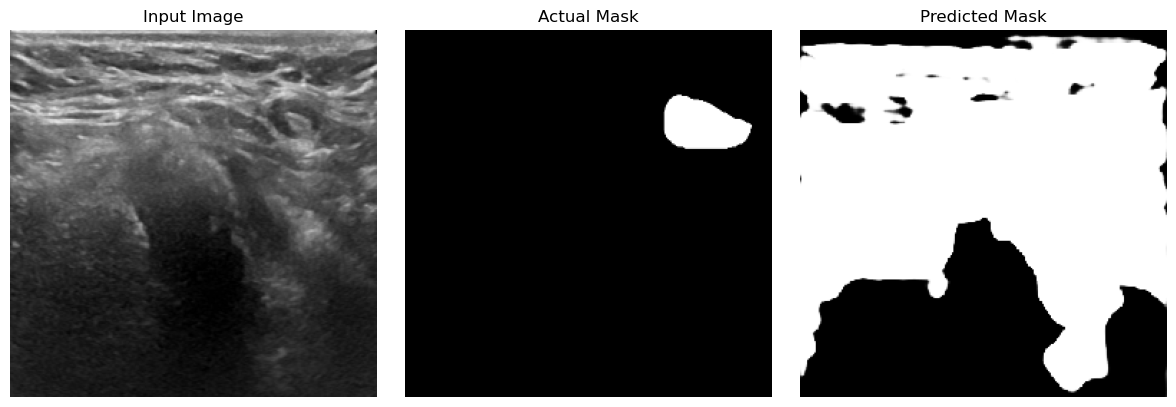

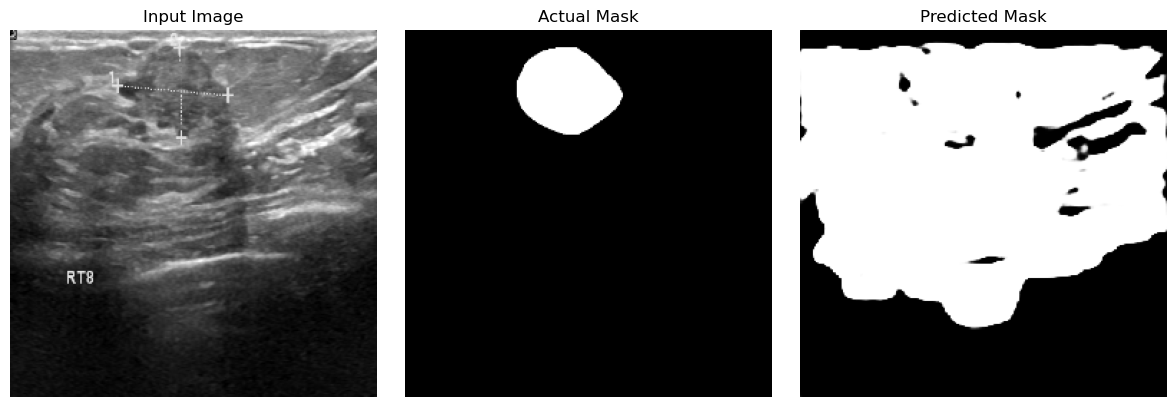

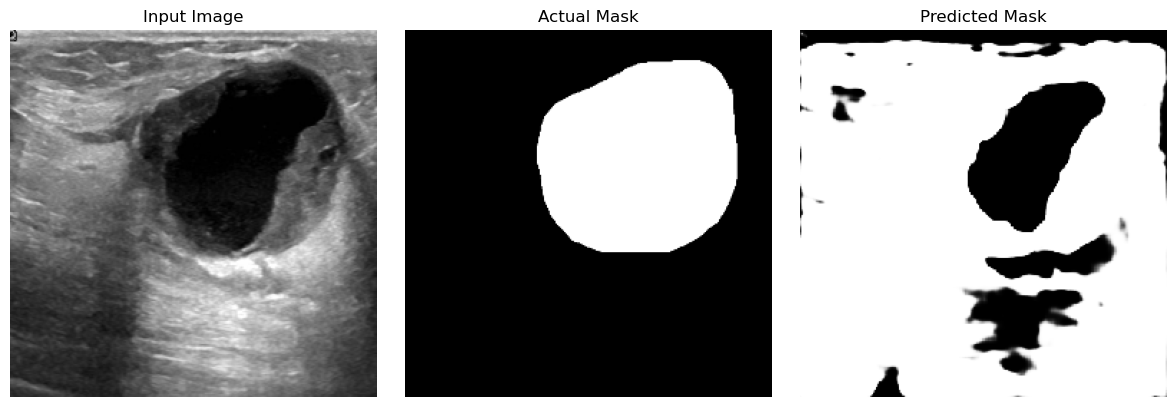

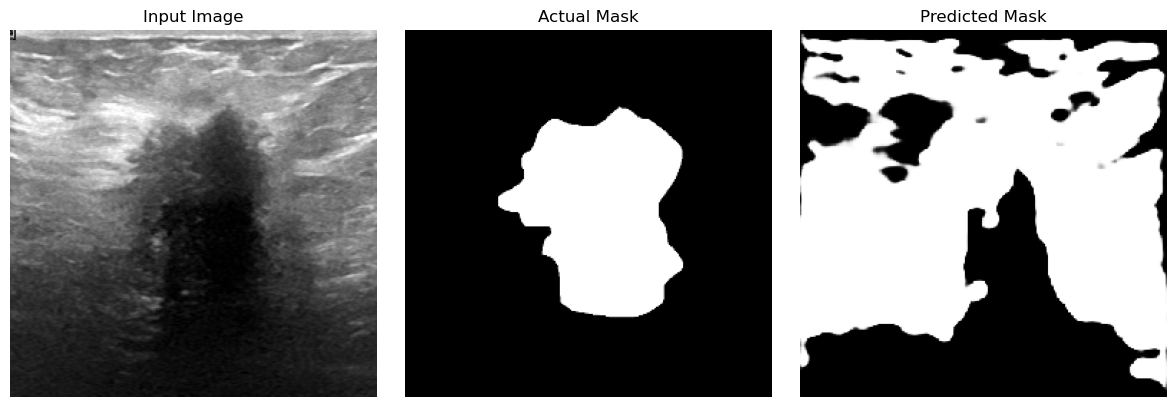

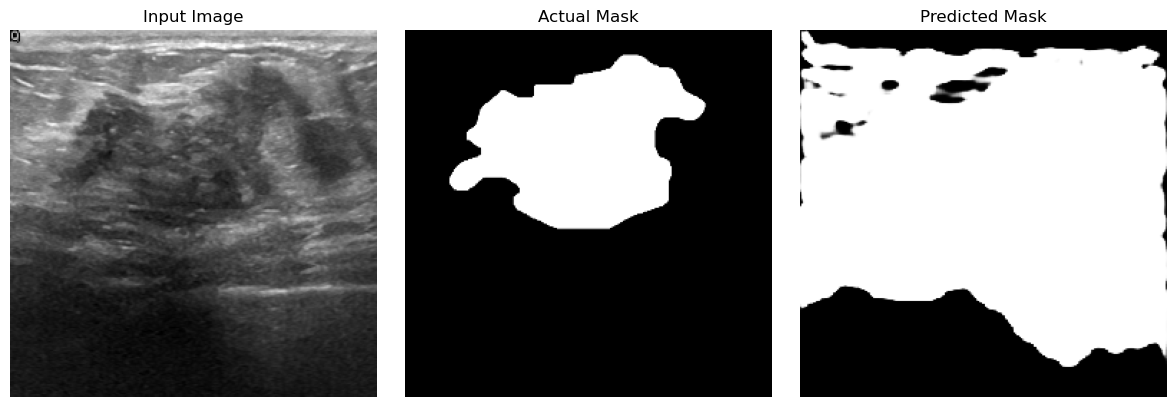

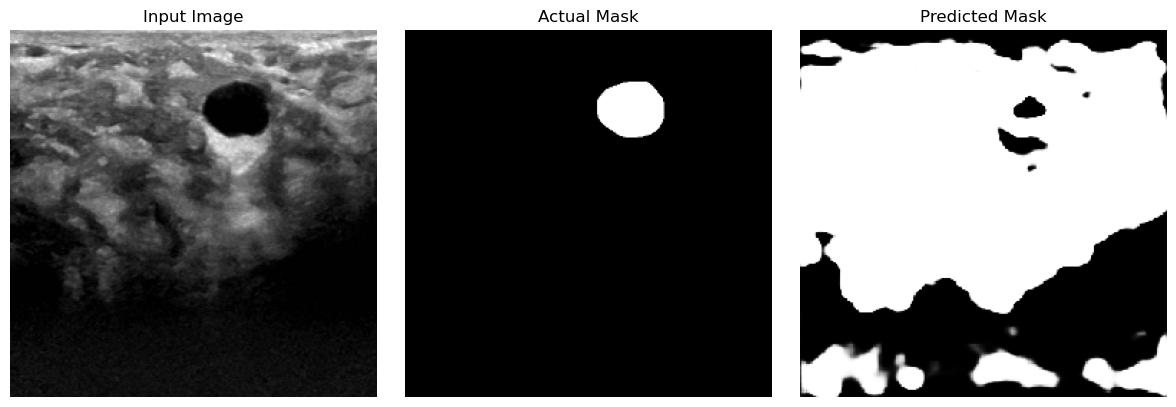

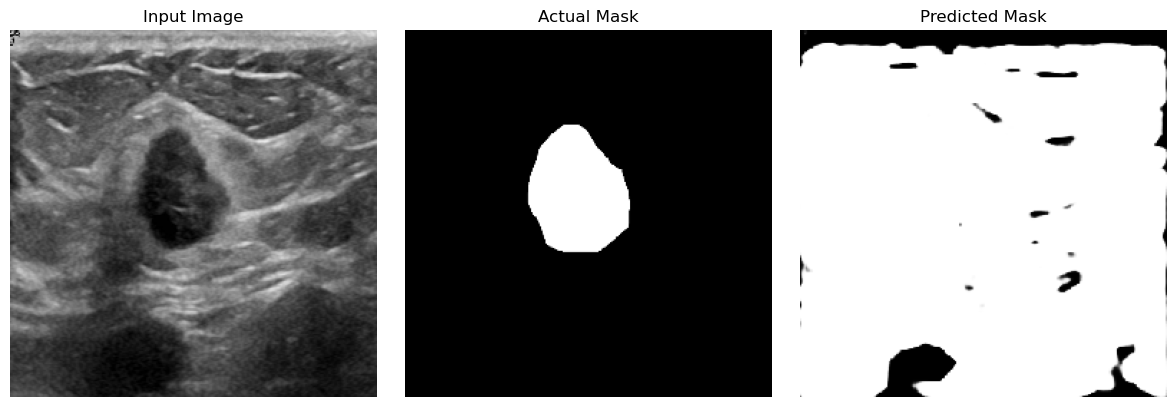

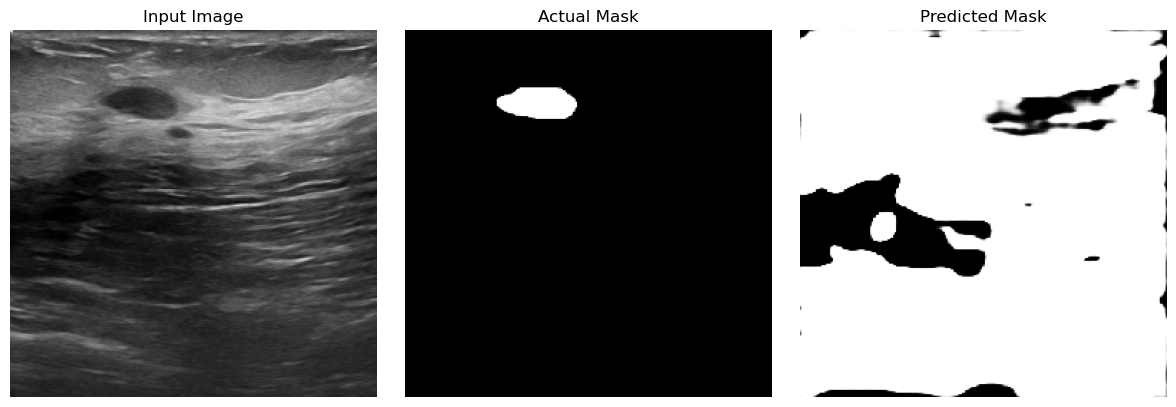

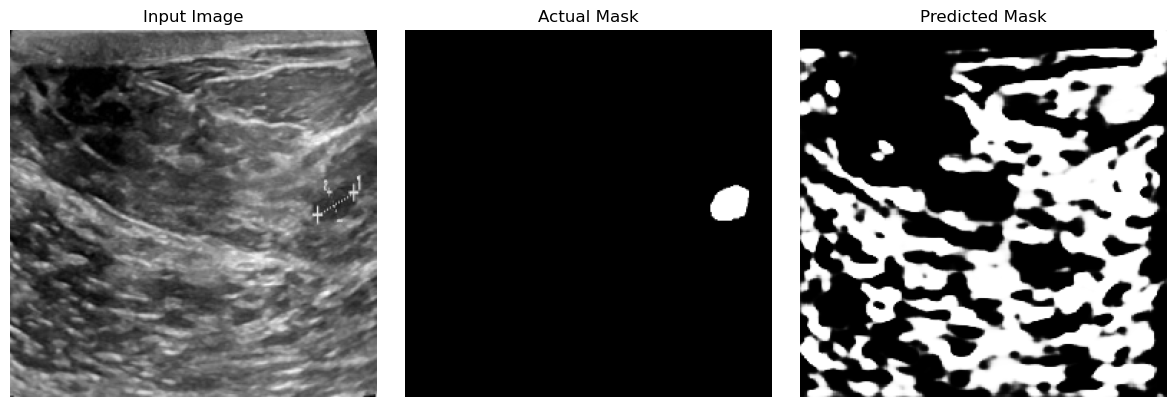

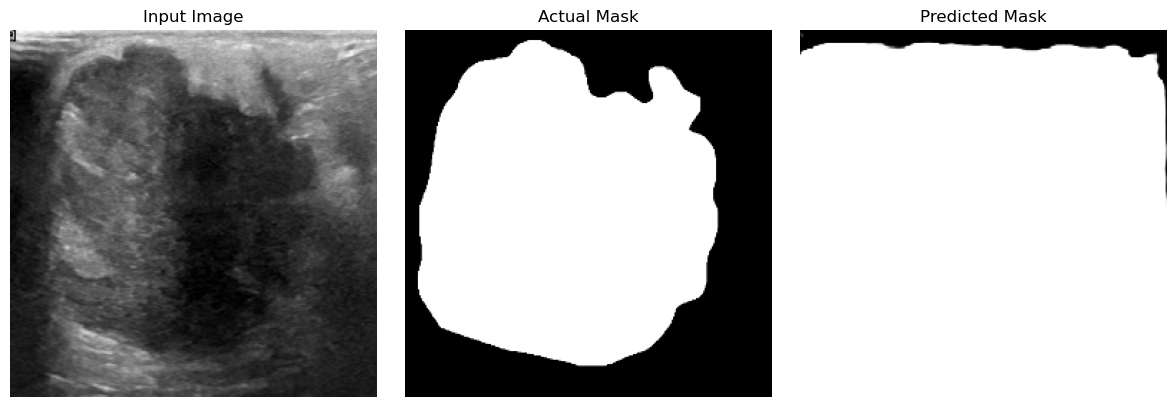

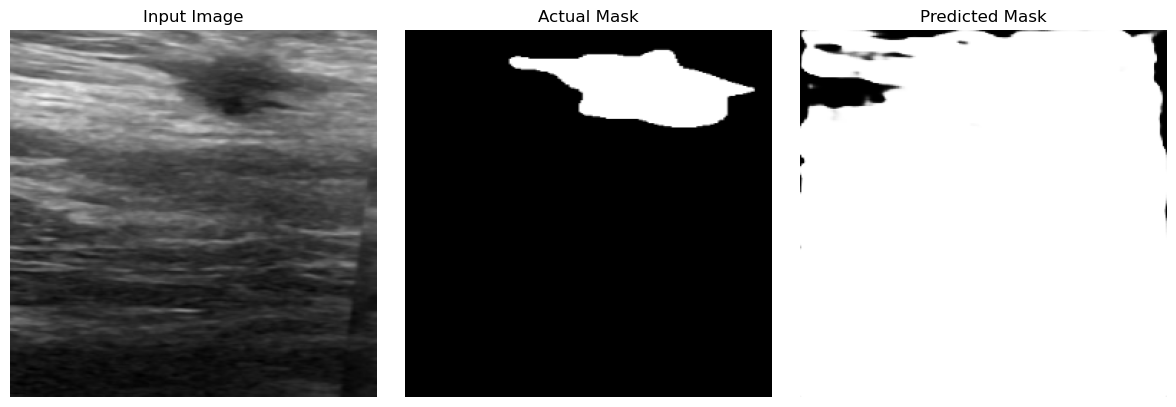

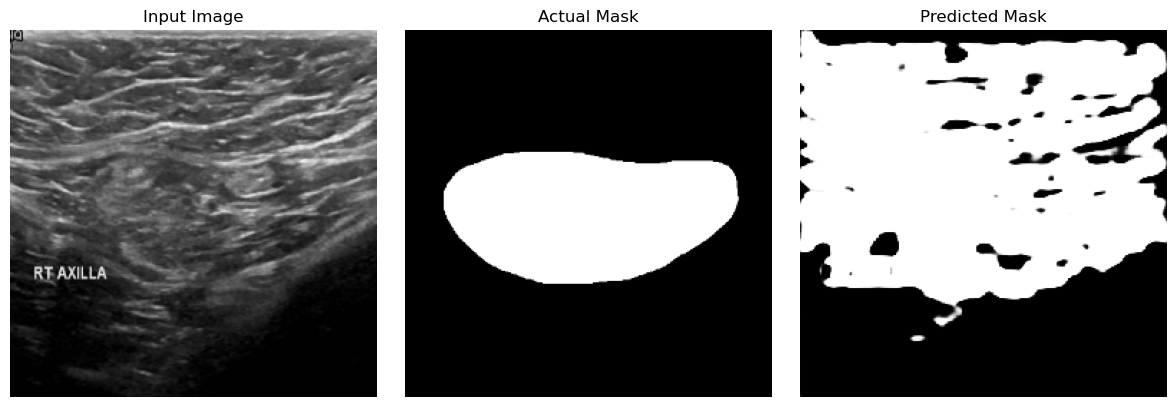

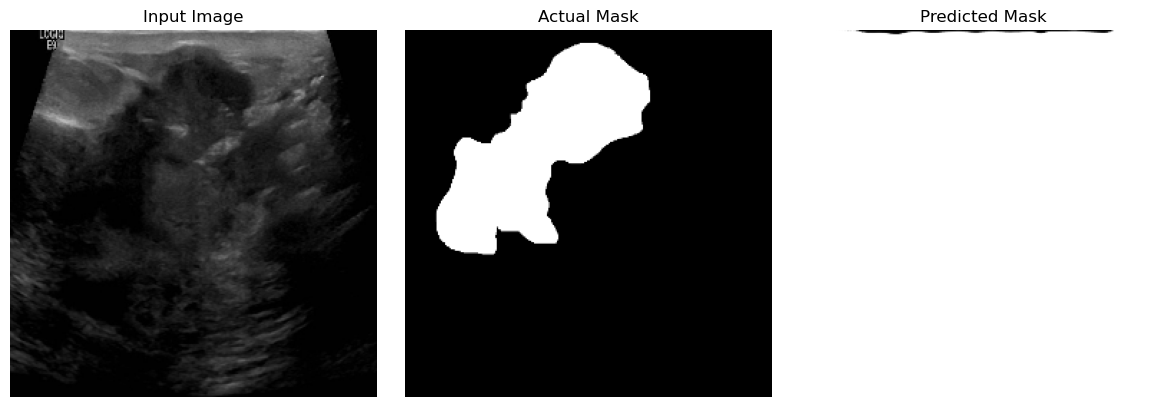

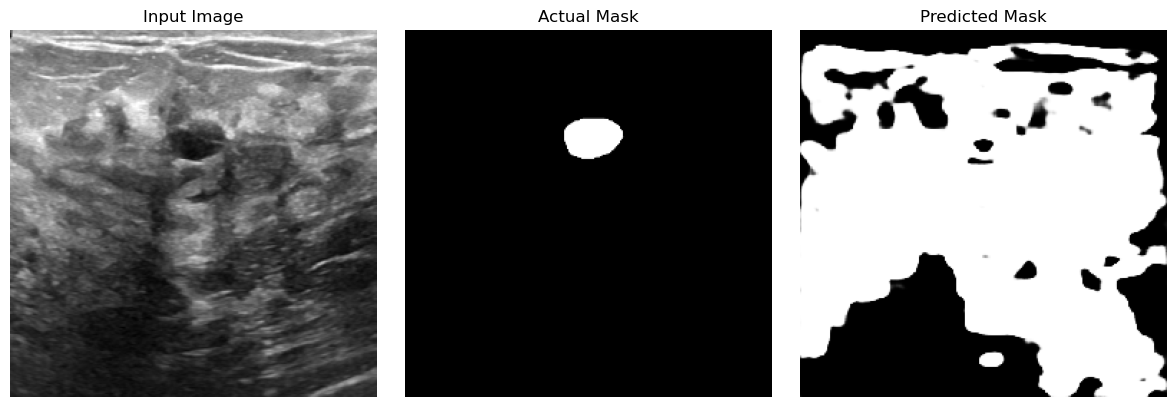

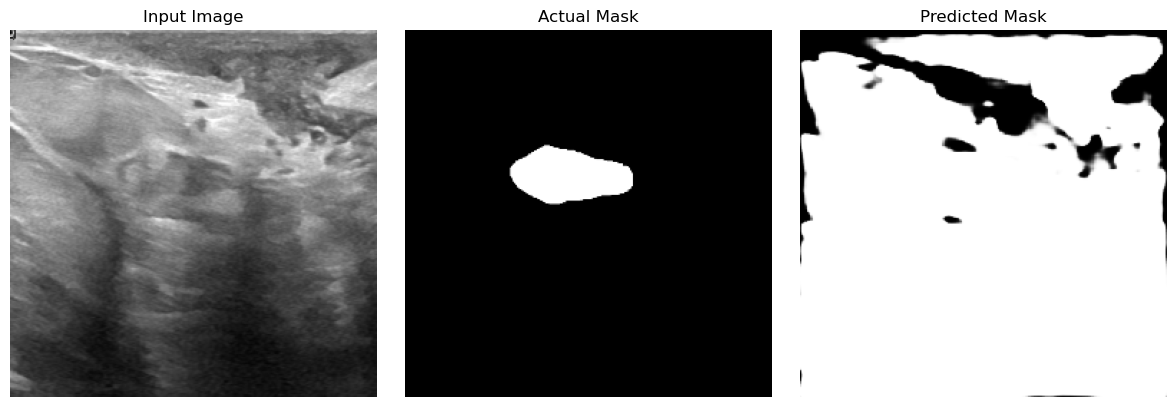

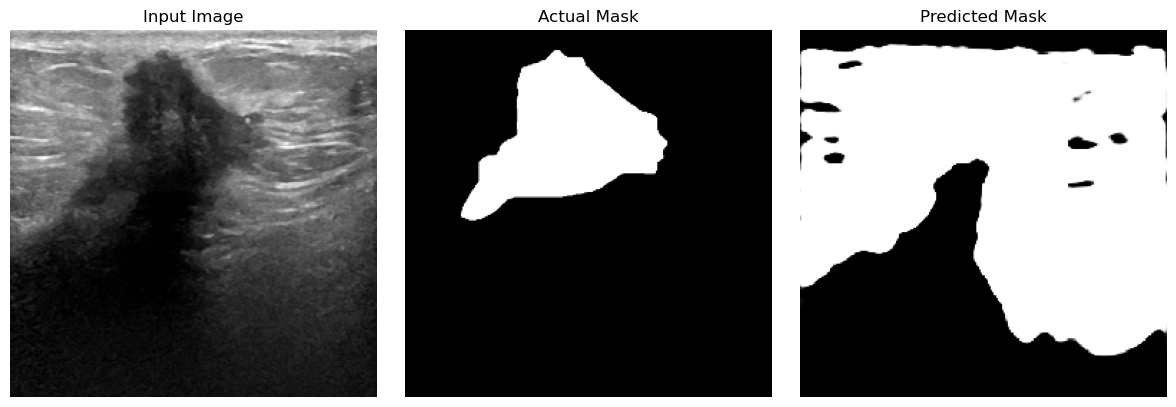

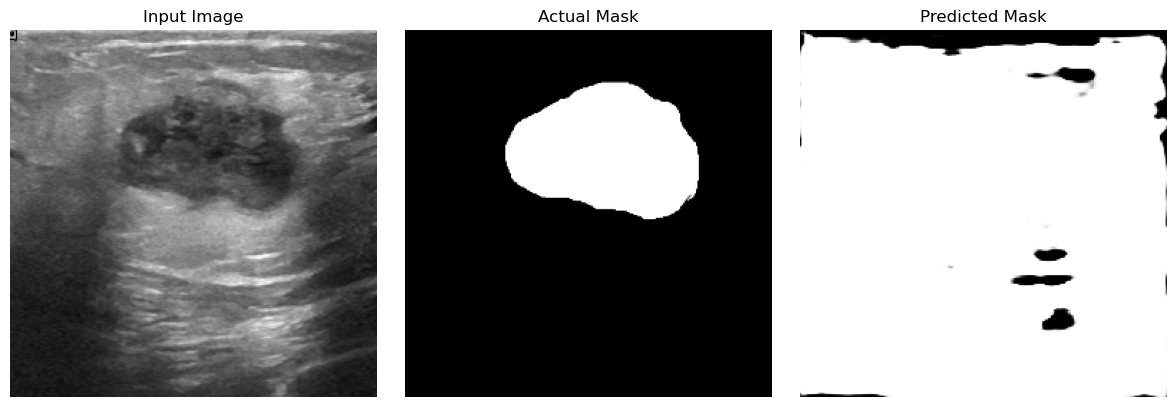

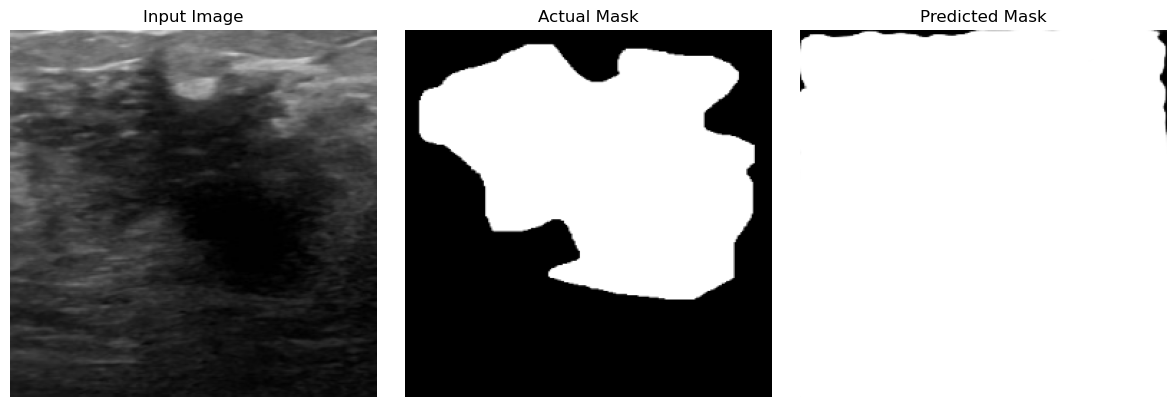

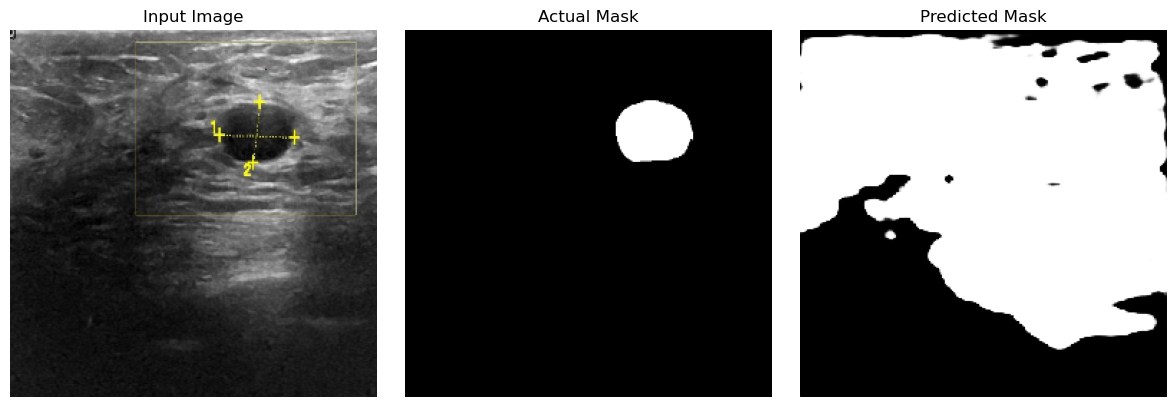

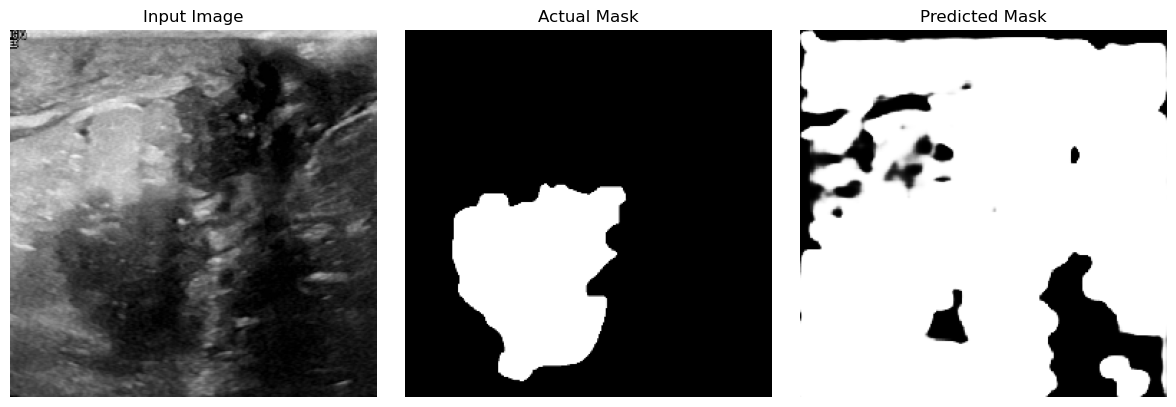

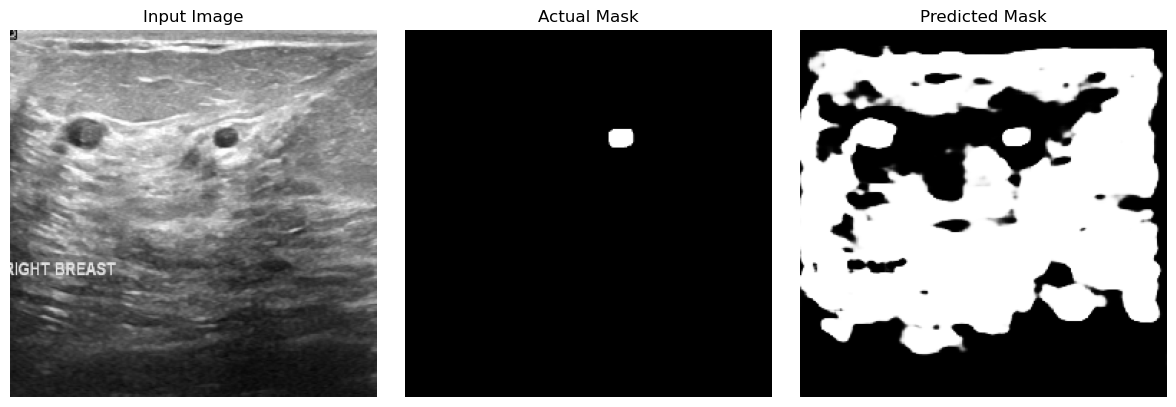

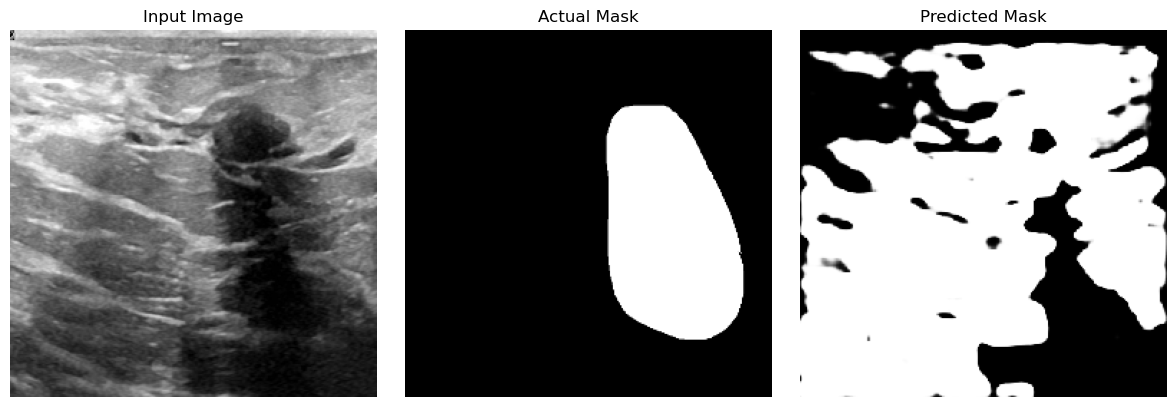

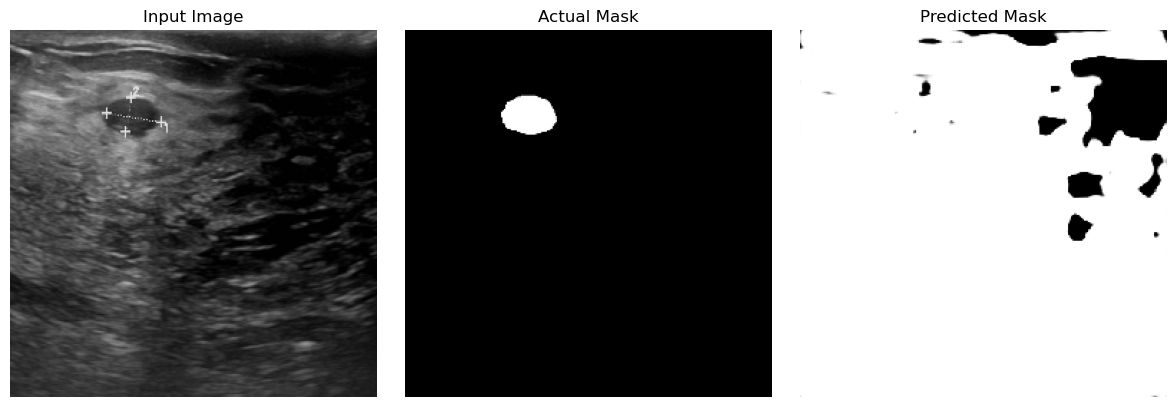

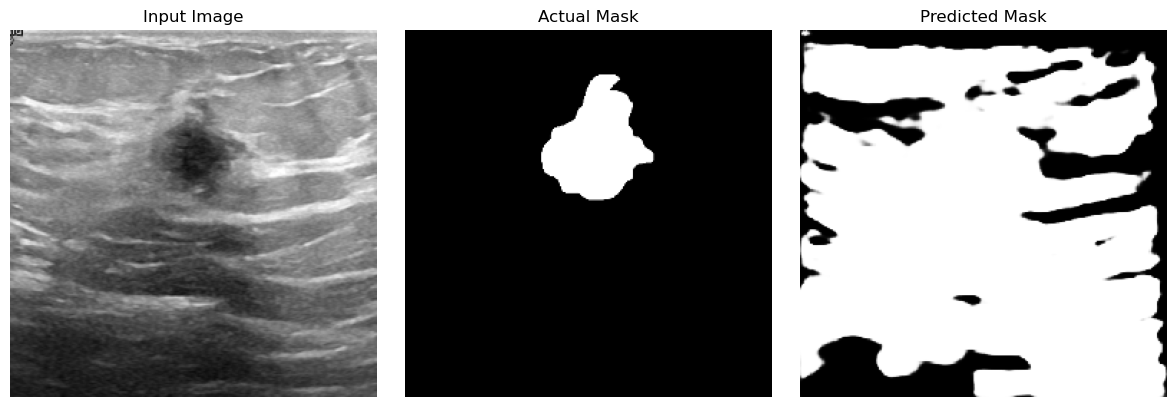

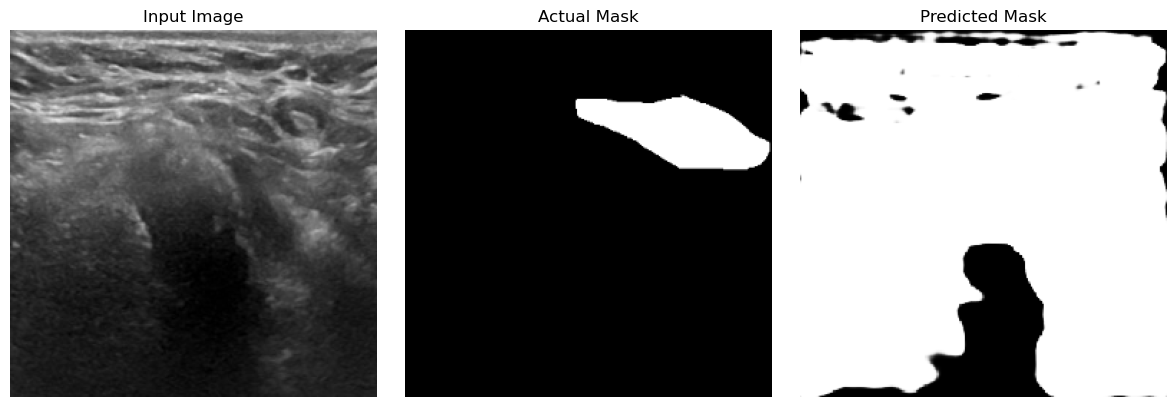

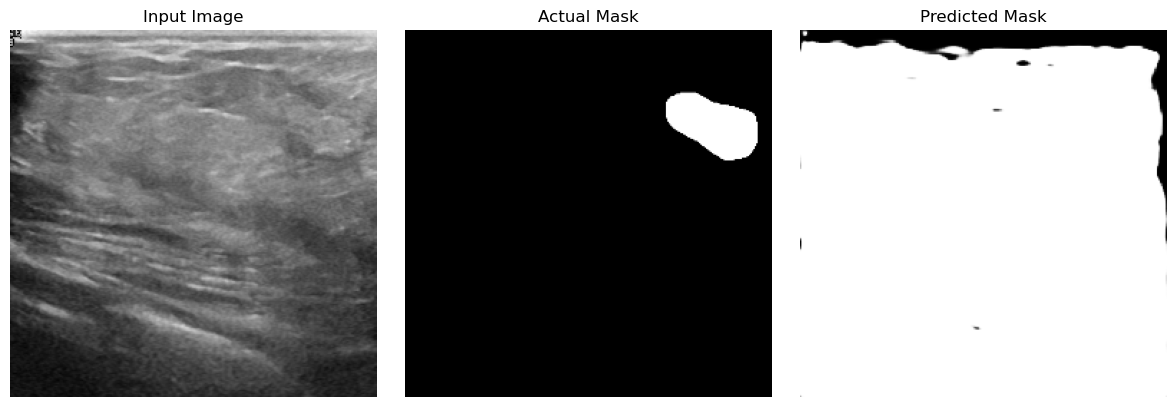

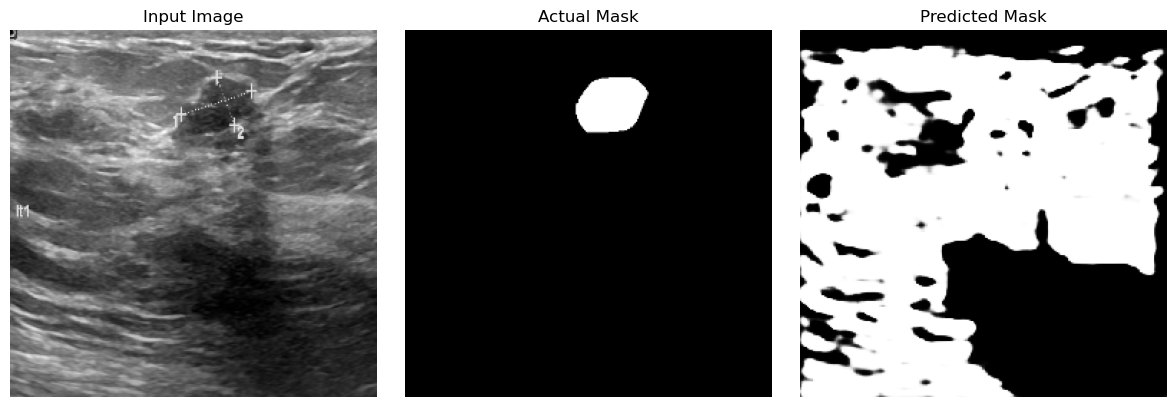

In [73]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = model.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [32]:
# pretrained_unet = basic_unet
# pretrained_unet.load_weights("basic_unet_tversky.h5")

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# lr_adapter = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", mode = "max", factor=0.1, patience=5, min_lr=0.00001)
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", mode= "max", patience=10, restore_best_weights=True)

# model = UCTransNet(pretrained_unet=None)
# model.compile(optimizer=optimizer,
#                          loss=tversky_loss,
#                          metrics=[dice_coefficient, iou, 'accuracy'])
# model.summary()
# # model.fit(train_dataset_breast, validation_data=val_dataset_breast, batch_size = 64, epochs=50, callbacks = [lr_adapter, early_stopping])